In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import os

In [2]:
# Displaying routine

def display_image(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None: 
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18,4))
            plt.suptitle(label + ' – real test data / reconstructions', color='b', fontsize=16)
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18,6))
            
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='b')


In [3]:
# set random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

os.cpu_count()

4

In [4]:
# define dataloading step 

BATCH_SIZE = 256
NUM_WORKERS = os.cpu_count()

kwargs = {'num_workers': 1, 'pin_memory': True}

train_data = MNIST(root='./data',
                  train=True,
                  download=True,
                  transform=transforms.ToTensor()
            )

test_data = MNIST(root='./data',
                  train=False,
                  download=True,
                  transform=transforms.ToTensor()
            )

train_dataloader = torch.utils.data.DataLoader(dataset=train_data, 
                                               batch_size=BATCH_SIZE,
#                                                num_workers=NUM_WORKERS,
                                               shuffle=True, 
                                               **kwargs
                                              )
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, 
                                               batch_size=BATCH_SIZE,
#                                                num_workers=NUM_WORKERS,
                                               shuffle=True,
                                               **kwargs
                                              )

In [5]:
# Defining the deivce

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
device

'cuda'

<center>
    <h1> Variational Autoencoder</h1>
</center>

<center><img src="https://github.com/saurabtharu/autoencoder/blob/main/images/vae/vae_arch.png?raw=true" style="height: 10;"></center>


<center>
    <h1> Variational Autoencoder : Working steps</h1>
</center>

<center><img src="https://github.com/saurabtharu/autoencoder/blob/main/images/vae/steps.png?raw=true" style="height: 10;"></center>

<center>
    <h1> Variational Autoencoder : Reparameterization</h1>
</center>

<center><img src="https://github.com/saurabtharu/autoencoder/blob/main/images/vae/reparameterization.png?raw=true" style="height: 10;"></center>

In [6]:
# Defining the model 

d = 20

class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, d ** 2),
            nn.ReLU(),
            nn.Linear(d**2, d * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(d, d**2),
            nn.ReLU(),
            nn.Linear(d ** 2, 28*28),
            nn.Sigmoid(),
        )
        
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
#         print(mu_logvar)
        mu= mu_logvar[:, 0, :]
#         print(mu_logvar)
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VariationalAutoEncoder().to(device)

`x` is the input image.
The input is passed through the encoder to obtain mean(mu) i.e. `E(X)` and log-variance(logvar) i.e. `V(x)` parameters.
The reparameterization trick is applied to get the latent representation `z`.
The latent representation is passed through the decoder to reconstruct the output
The reconstructed output, mean, and log-variance are returned.



Here reparameterization trick enables the backpropagation of gradients through the sampling process
reparameterization trick is to express the sampling operation as a deterministic transformation of the distribution's parameters and a noise term sampled from a fixed distribution (typically a standard normal distribution


In [7]:
# setting the optimizer
LR = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR
)

<center>
    <h1> Variational Autoencoder : Loss function</h1>
</center>

<center><img src="https://github.com/saurabtharu/autoencoder/blob/main/images/vae/loss_function_vae.png?raw=true" style="height: 10;"></center>

In [8]:
# reconstruction + KL Divergence losses around summed over all elements
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 28*28),reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return BCE + KLD

# Image interpretation

Image in first row in the result indicates the original image and second row indicates reconstructed image on each epoch

In [9]:
from tqdm.auto import tqdm

  0%|          | 0/51 [00:00<?, ?it/s]

========> Test set loss : 543.2947
====> Epoch : 1 Average loss = 188.5770
========> Test set loss : 135.5327
====> Epoch : 2 Average loss = 132.1926
========> Test set loss : 115.3885
====> Epoch : 3 Average loss = 120.9094
========> Test set loss : 108.5629
====> Epoch : 4 Average loss = 116.1902
========> Test set loss : 105.0773
====> Epoch : 5 Average loss = 113.4074
========> Test set loss : 102.6768
====> Epoch : 6 Average loss = 111.5855
========> Test set loss : 101.3353
====> Epoch : 7 Average loss = 110.3284
========> Test set loss : 100.2012
====> Epoch : 8 Average loss = 109.3523
========> Test set loss : 99.6364
====> Epoch : 9 Average loss = 108.6171
========> Test set loss : 98.6798
====> Epoch : 10 Average loss = 108.0005
========> Test set loss : 98.1620


/tmp/ipykernel_26/2719375229.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18,4))


====> Epoch : 11 Average loss = 107.4669
========> Test set loss : 98.0935
====> Epoch : 12 Average loss = 107.0376
========> Test set loss : 97.6376
====> Epoch : 13 Average loss = 106.6602
========> Test set loss : 97.4326
====> Epoch : 14 Average loss = 106.3327
========> Test set loss : 97.1352
====> Epoch : 15 Average loss = 105.9992
========> Test set loss : 96.4981
====> Epoch : 16 Average loss = 105.7279
========> Test set loss : 96.4784
====> Epoch : 17 Average loss = 105.5226
========> Test set loss : 97.3922
====> Epoch : 18 Average loss = 105.3072
========> Test set loss : 95.7471
====> Epoch : 19 Average loss = 105.0945
========> Test set loss : 96.0422
====> Epoch : 20 Average loss = 104.9051
========> Test set loss : 96.9576
====> Epoch : 21 Average loss = 104.7502
========> Test set loss : 95.5954
====> Epoch : 22 Average loss = 104.5875
========> Test set loss : 95.5939
====> Epoch : 23 Average loss = 104.4364
========> Test set loss : 95.0502
====> Epoch : 24 Average 

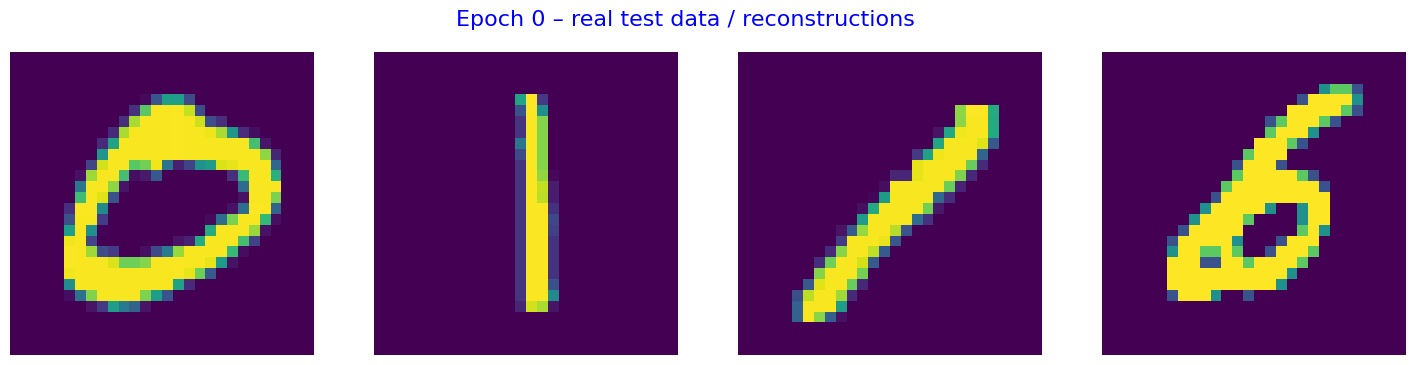

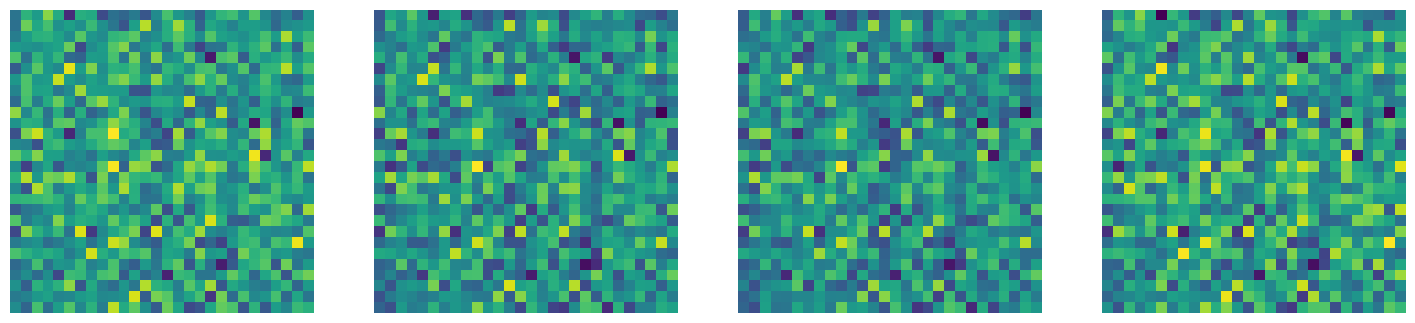

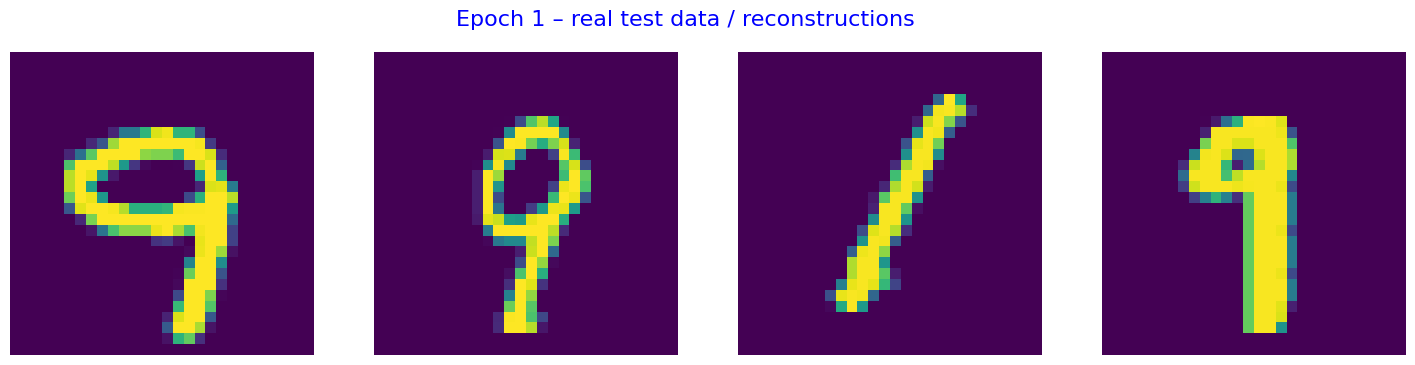

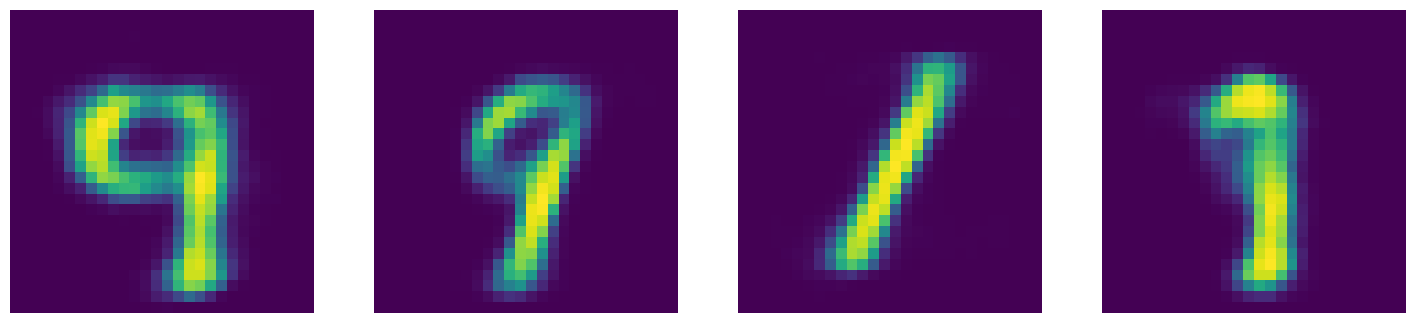

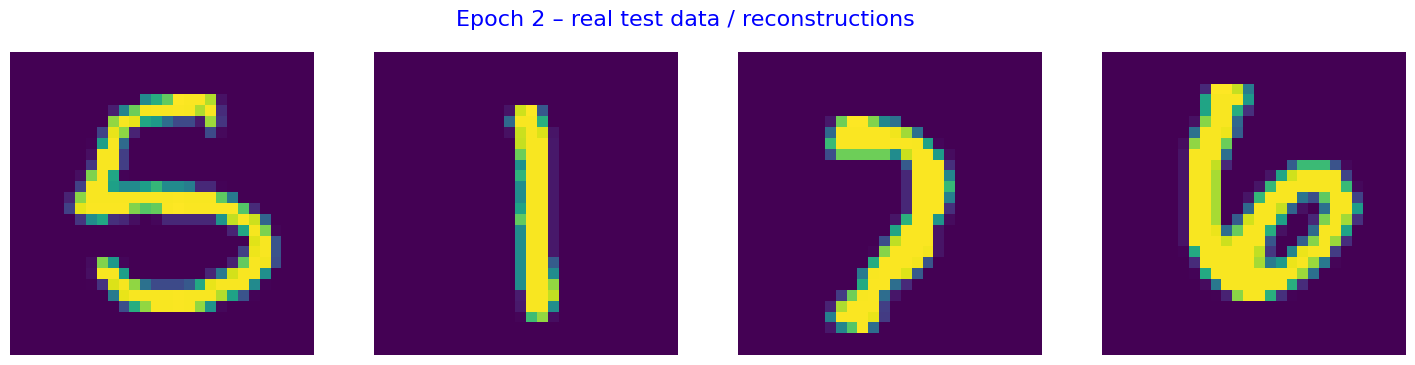

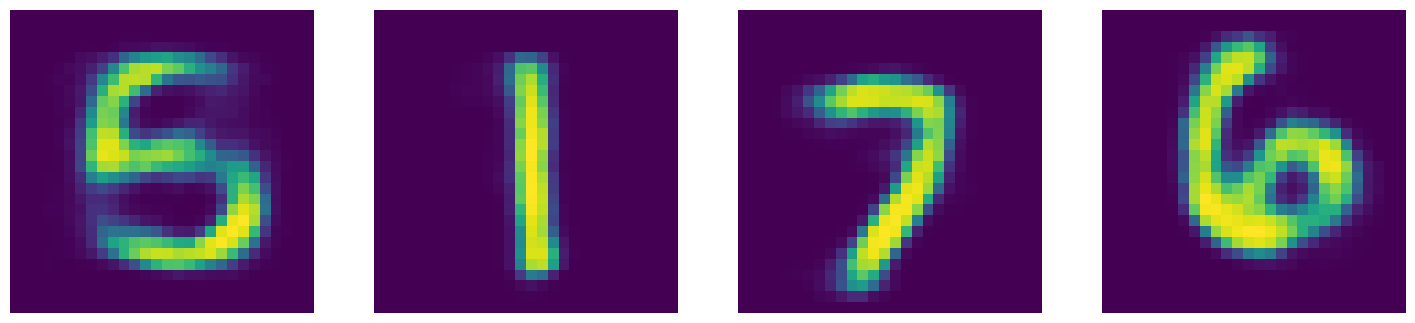

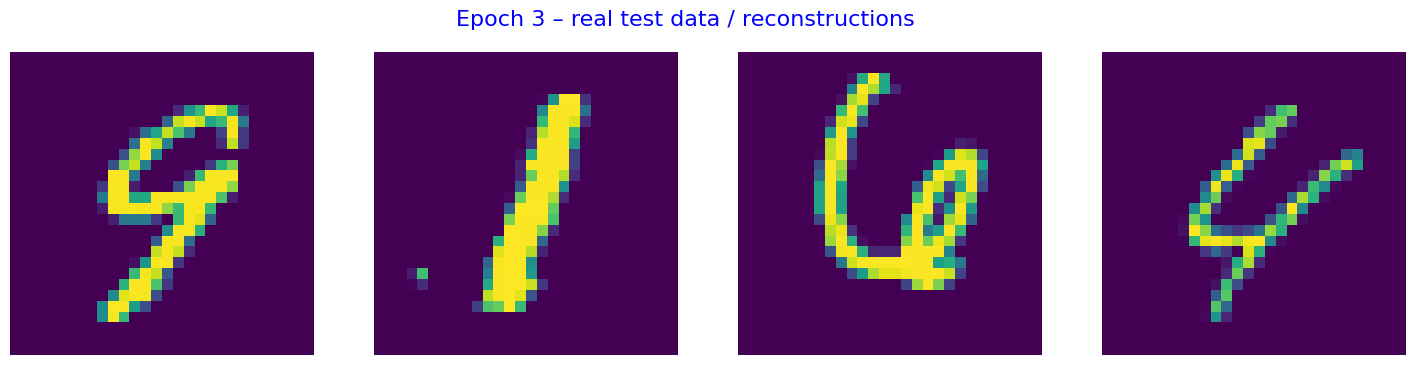

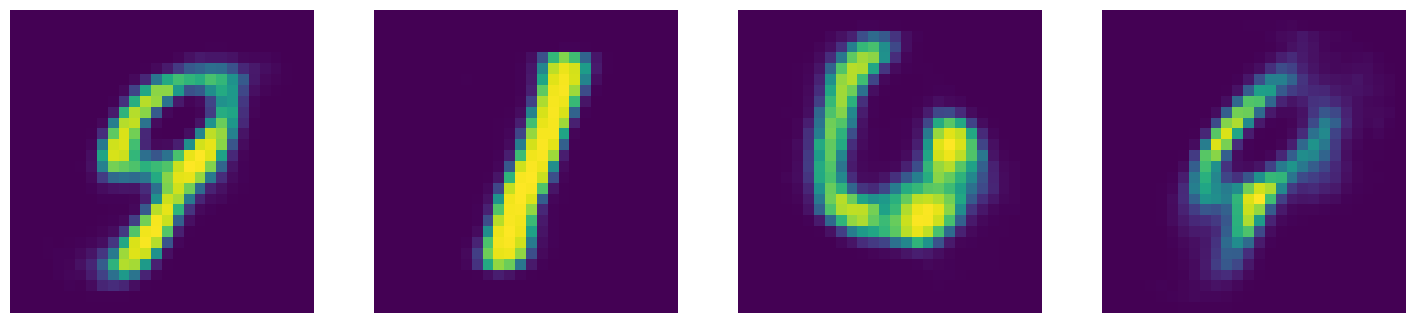

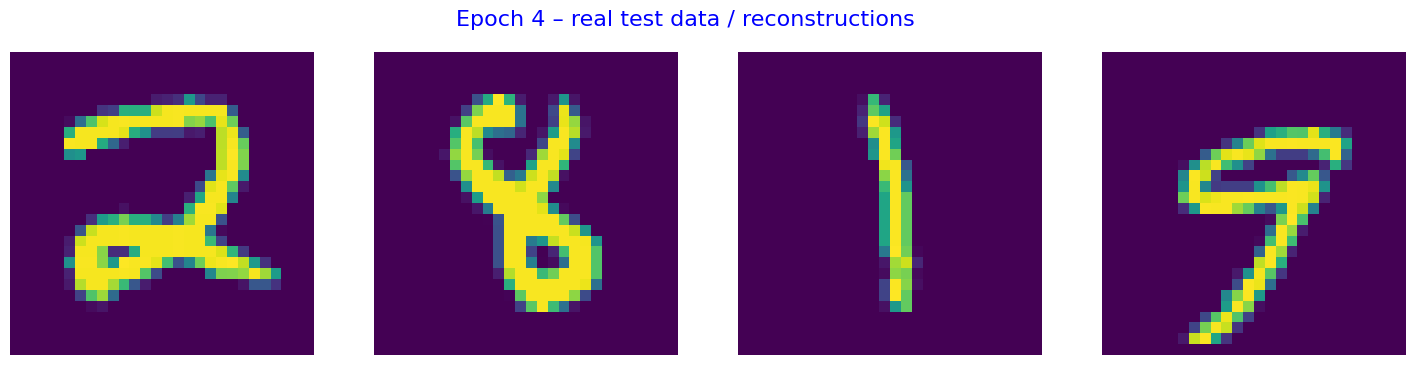

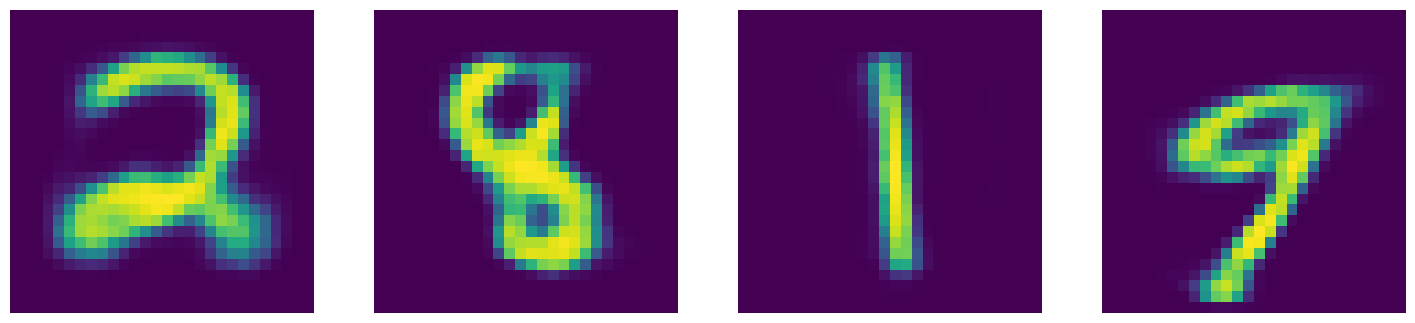

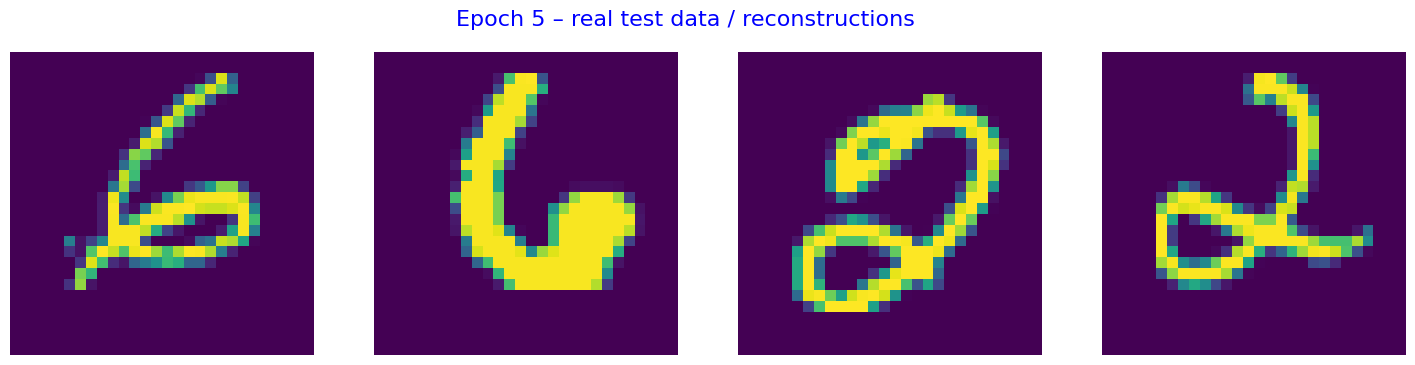

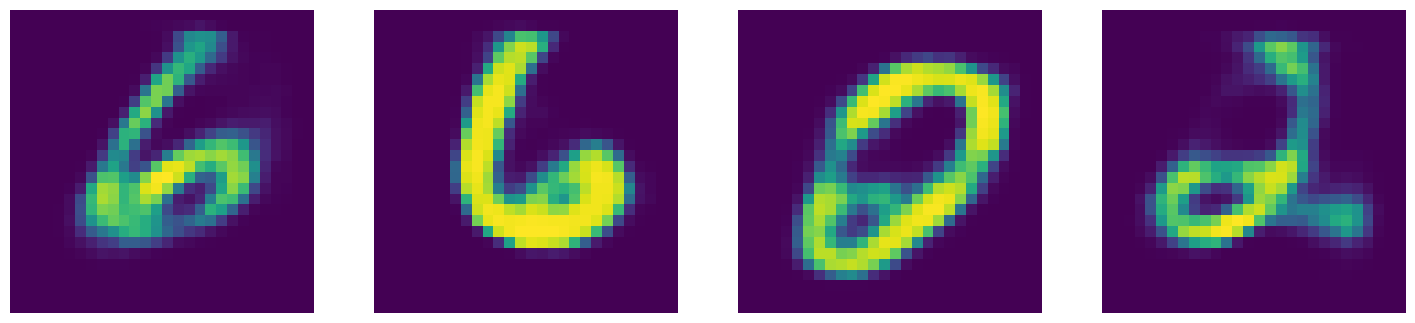

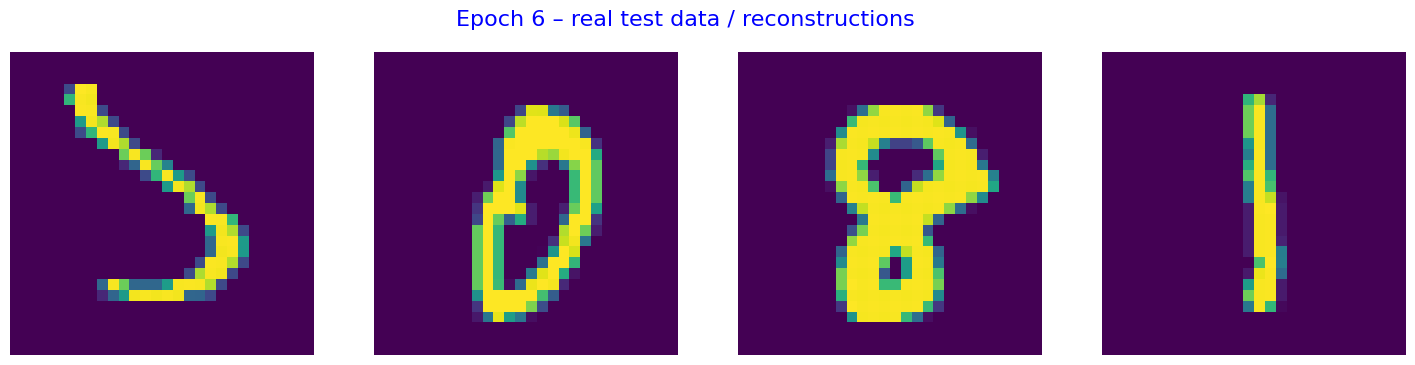

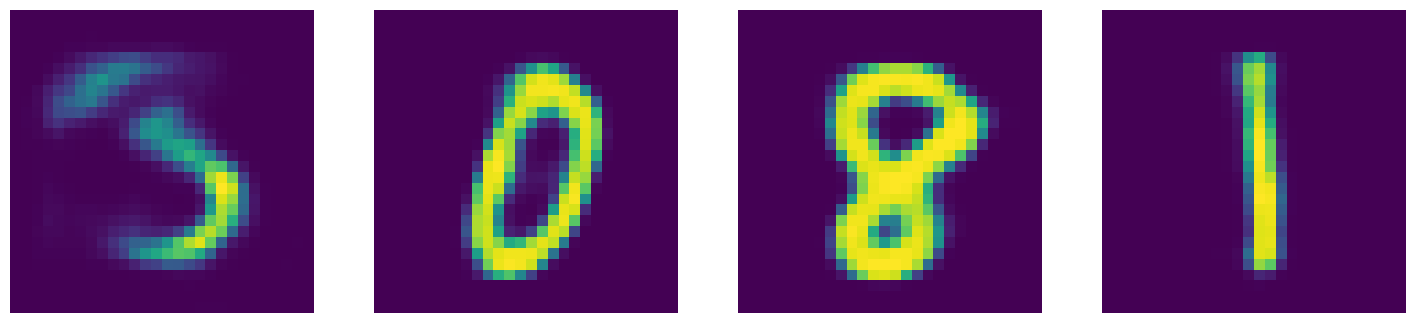

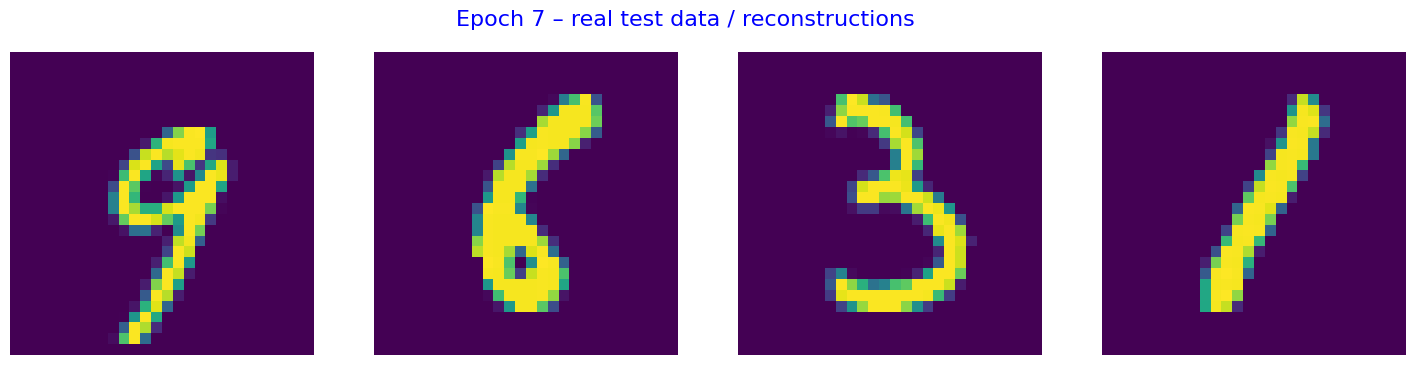

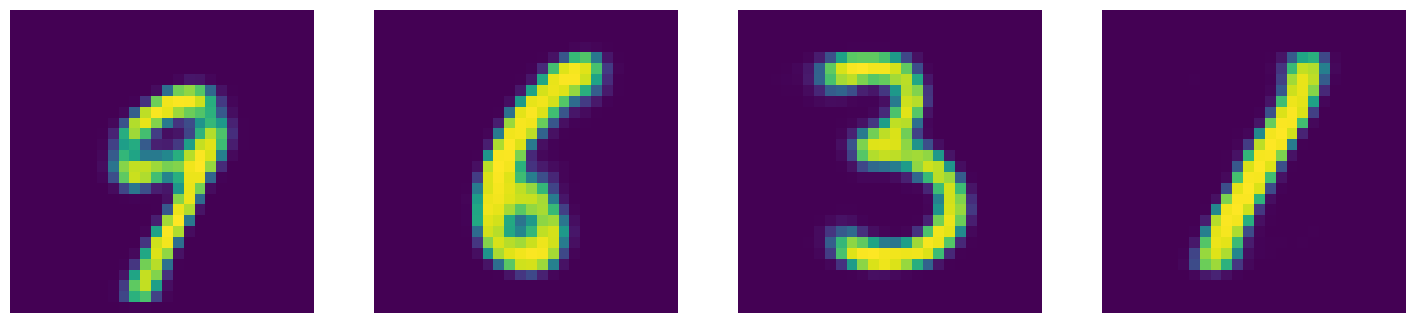

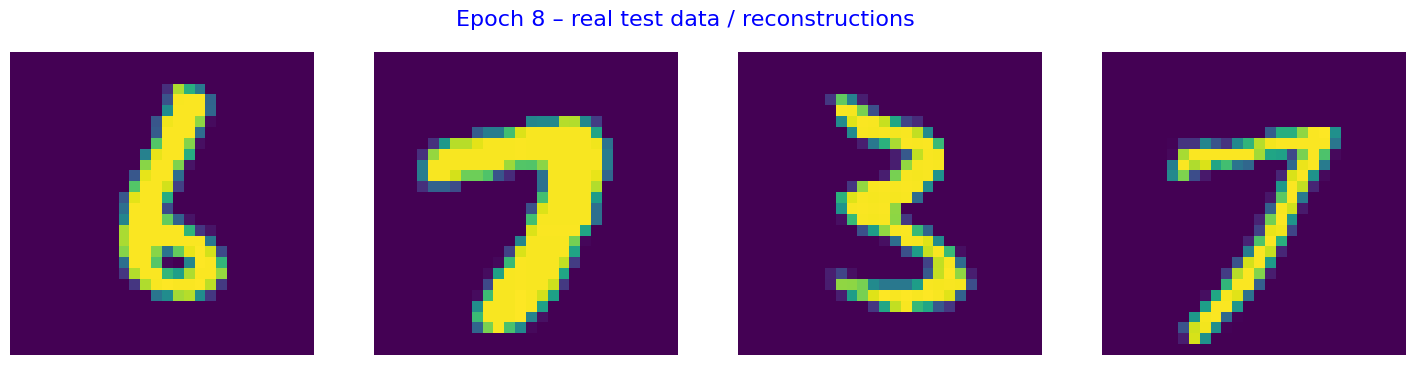

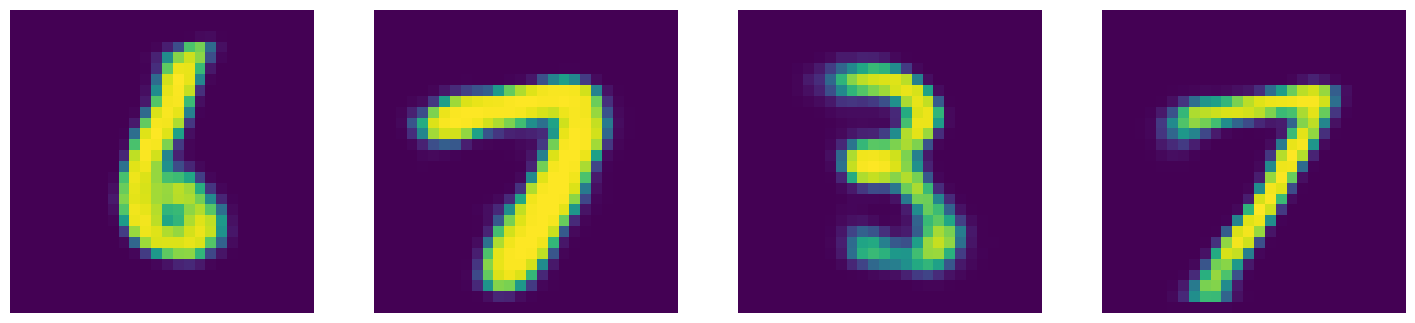

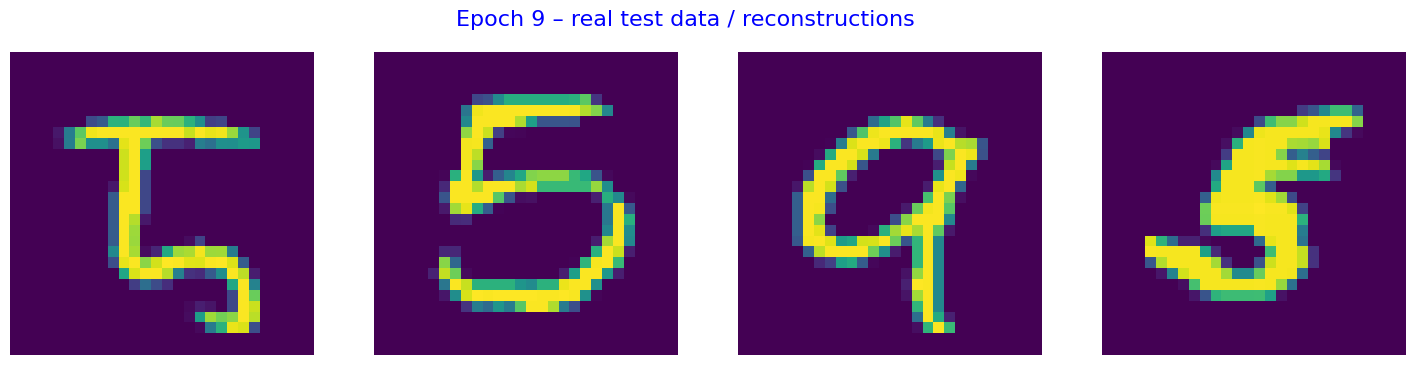

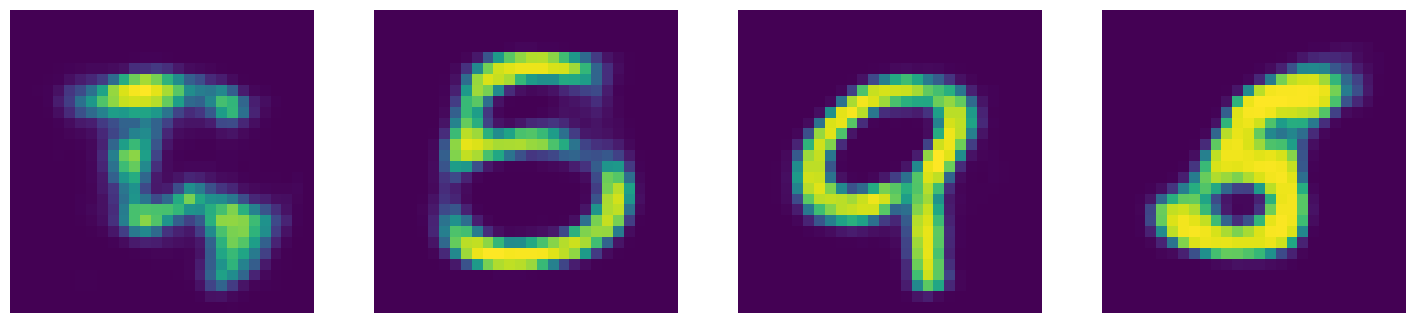

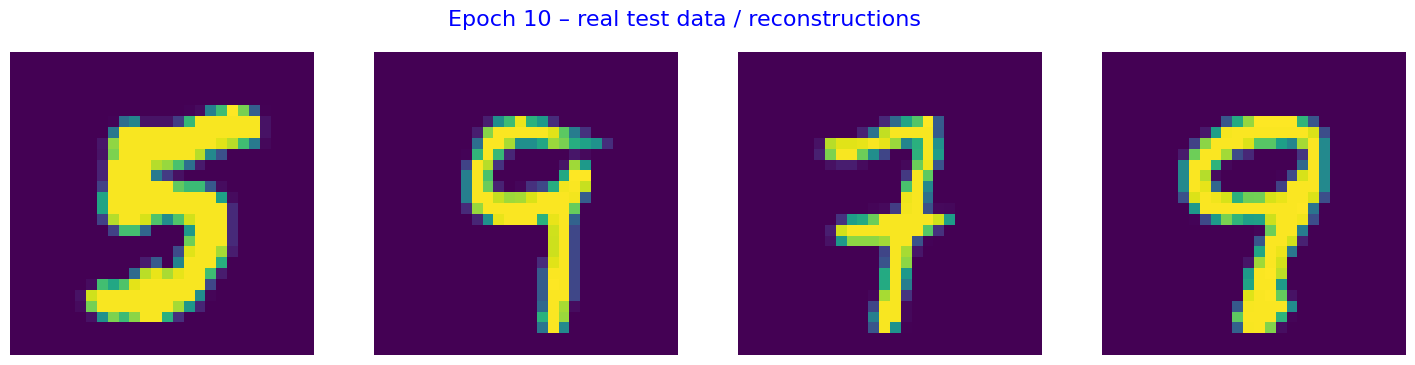

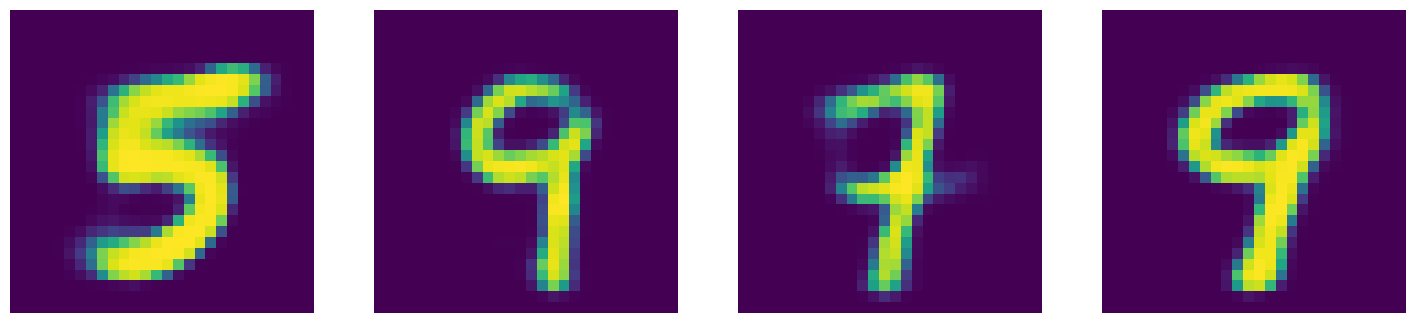

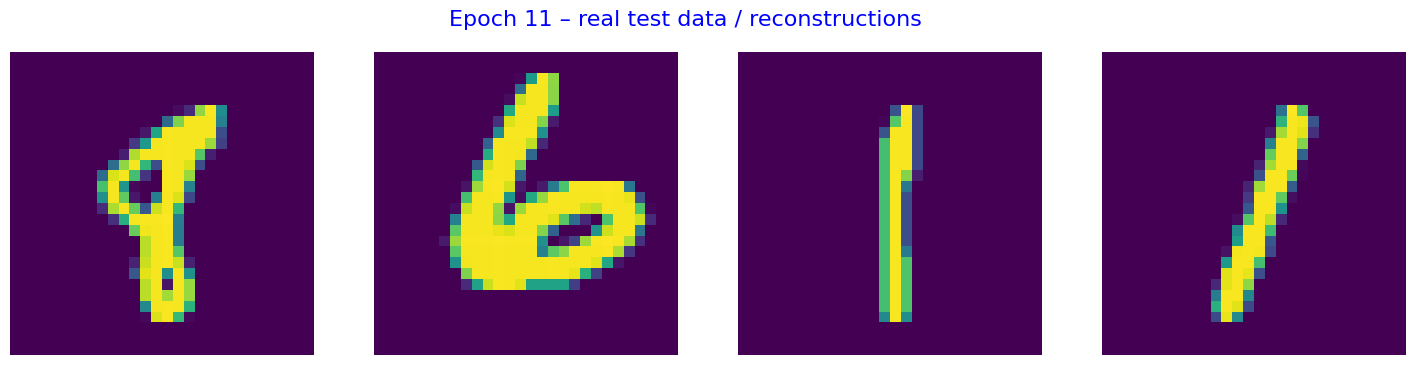

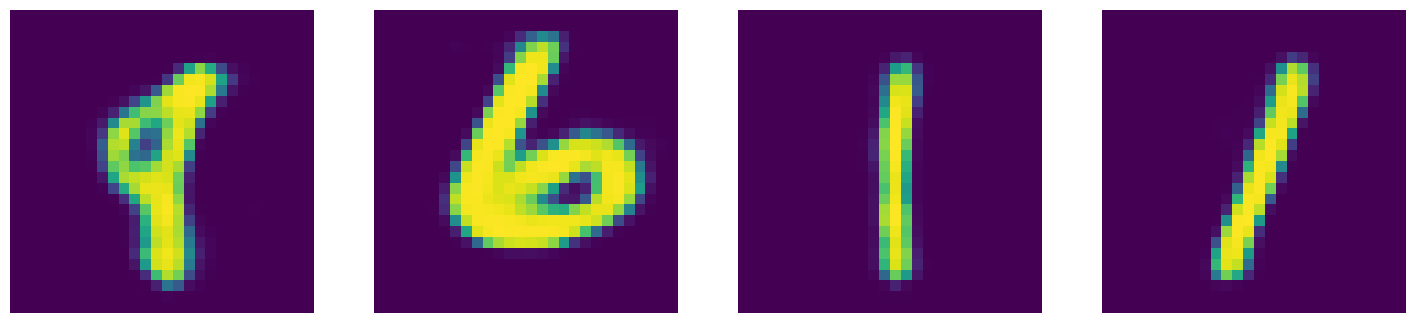

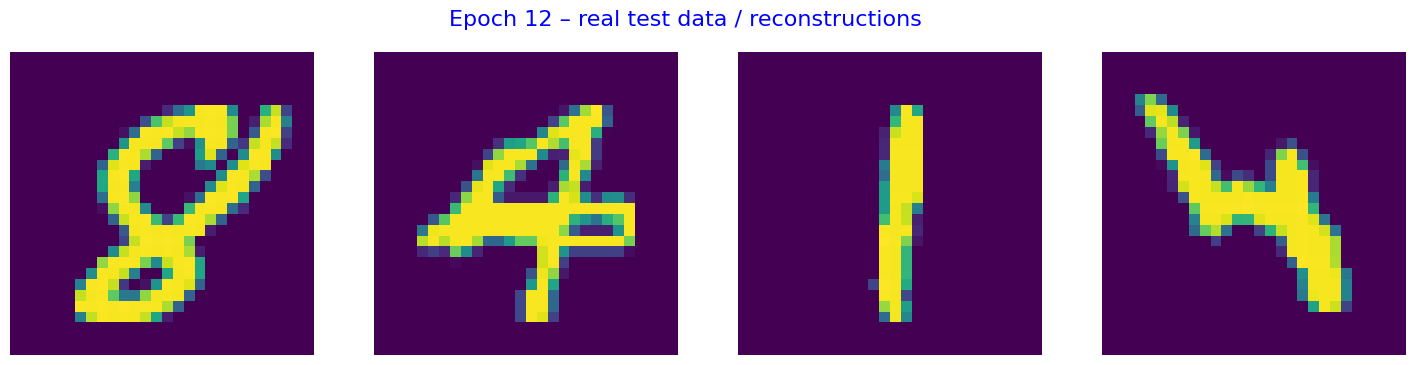

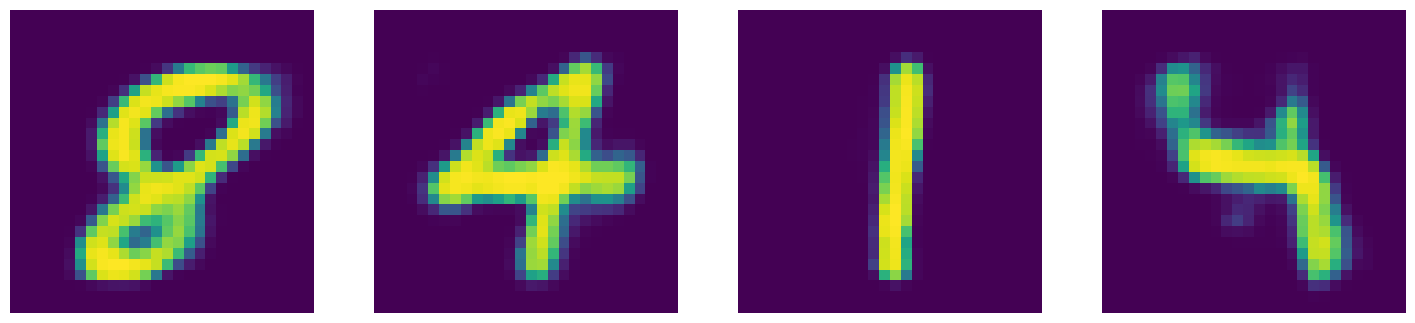

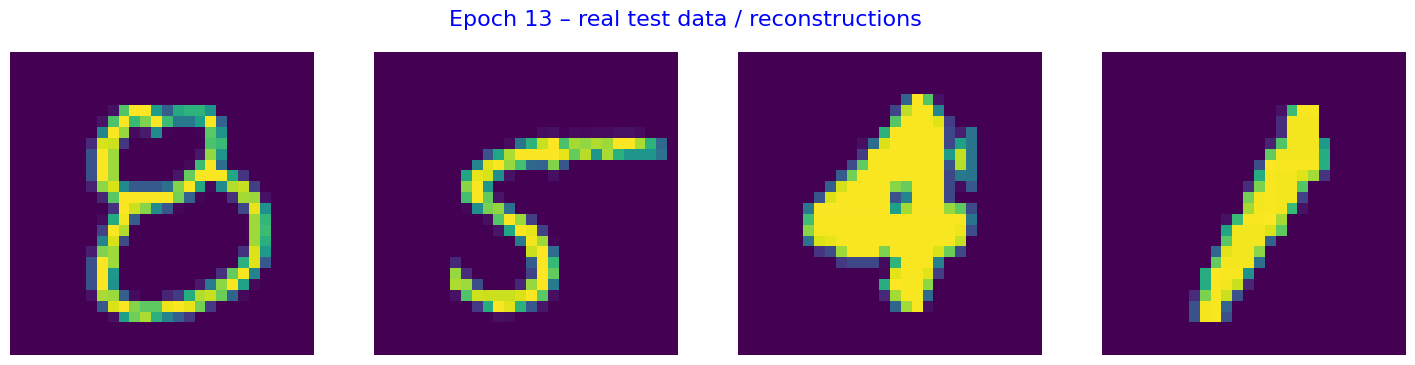

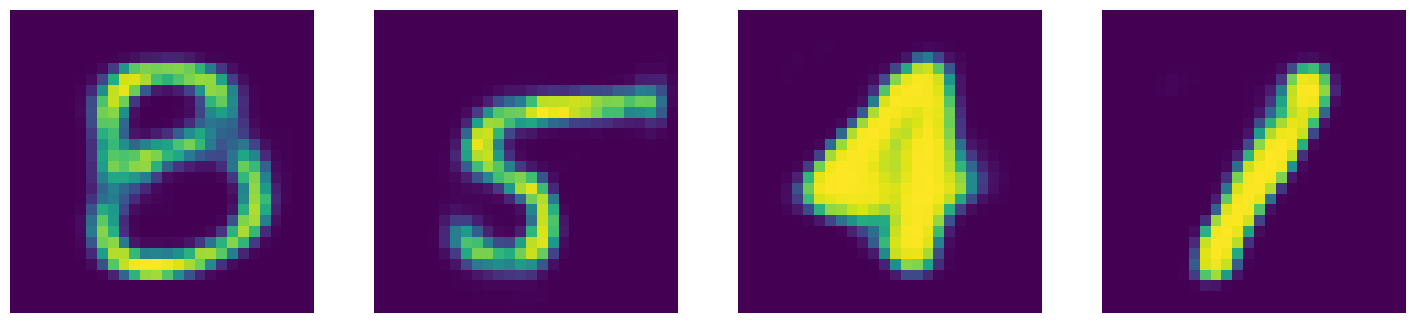

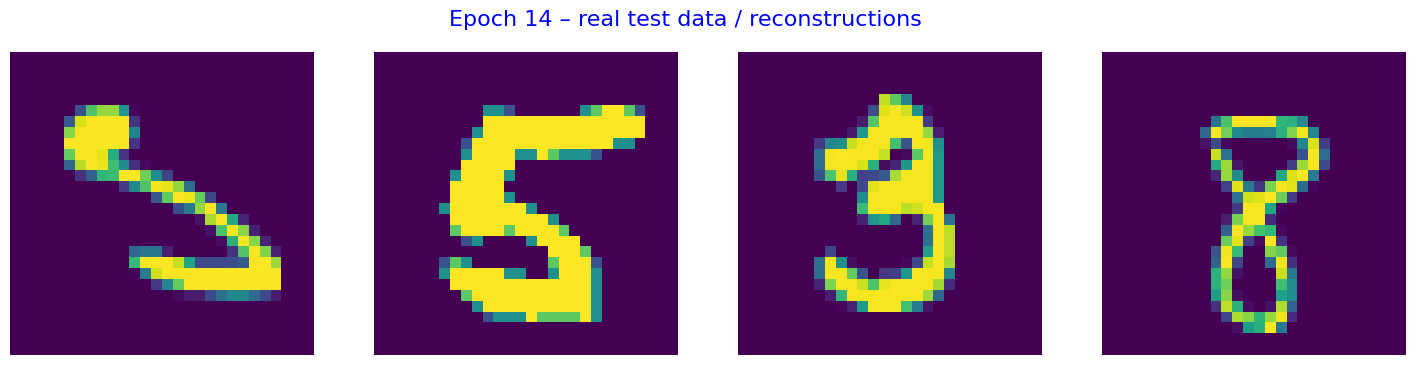

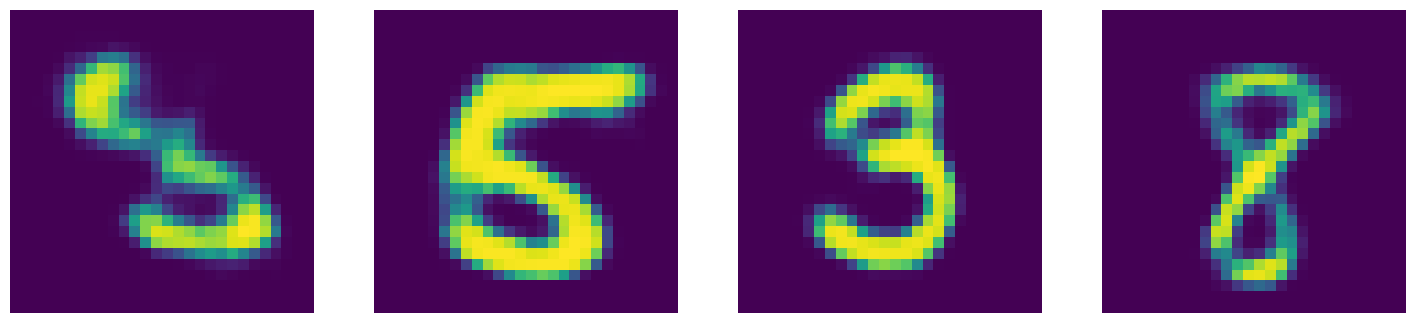

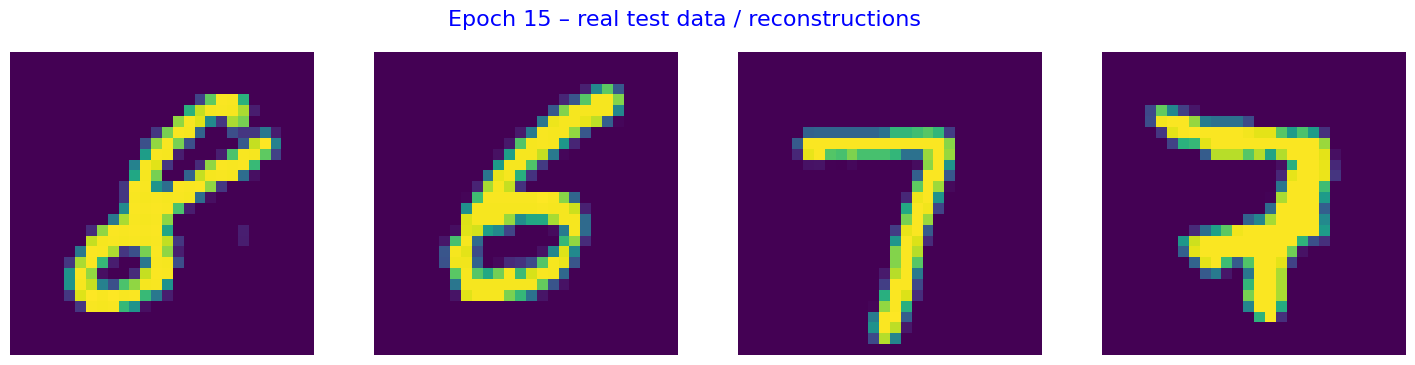

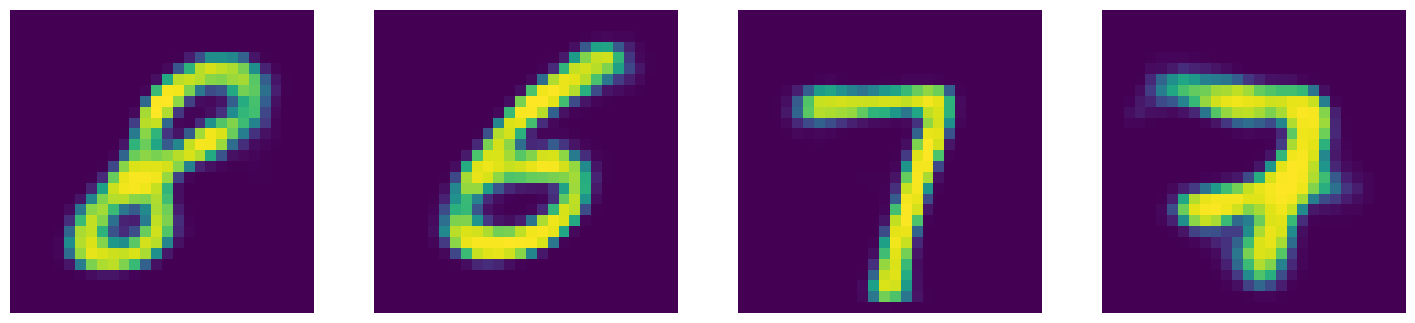

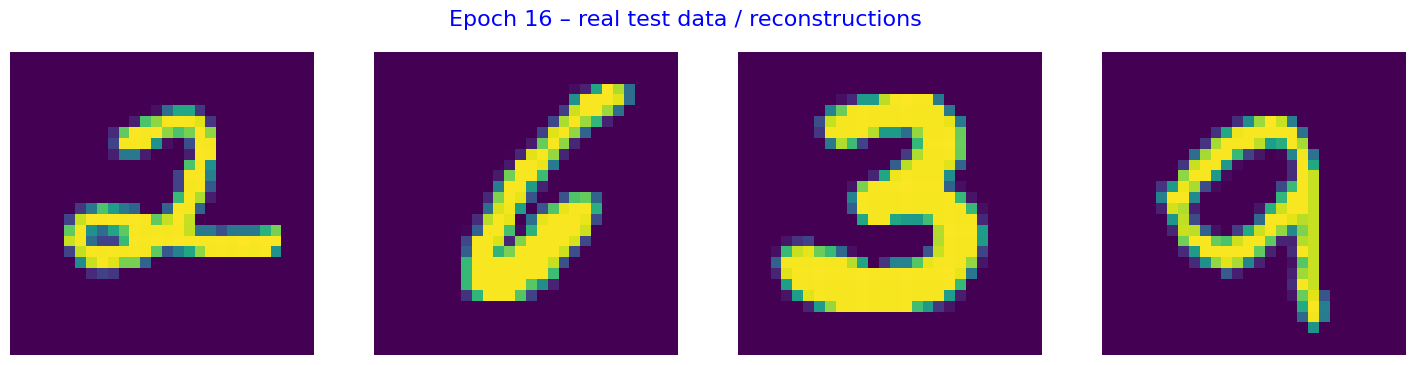

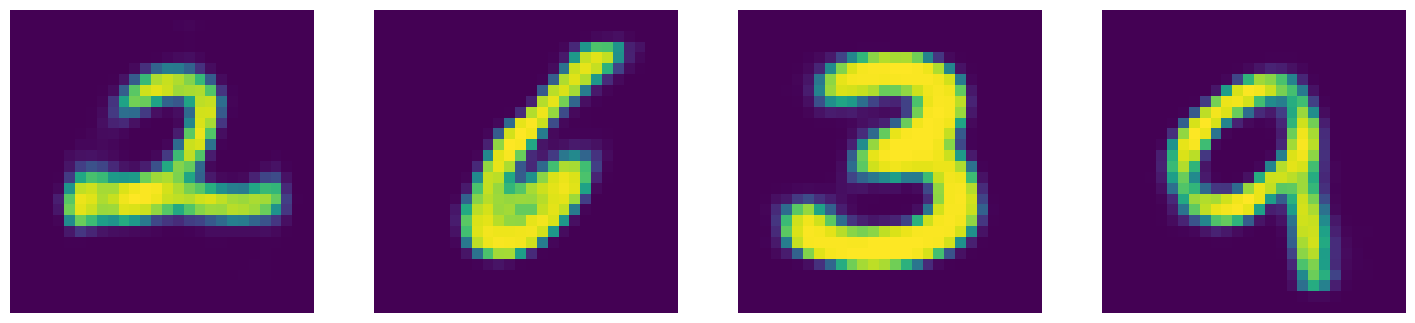

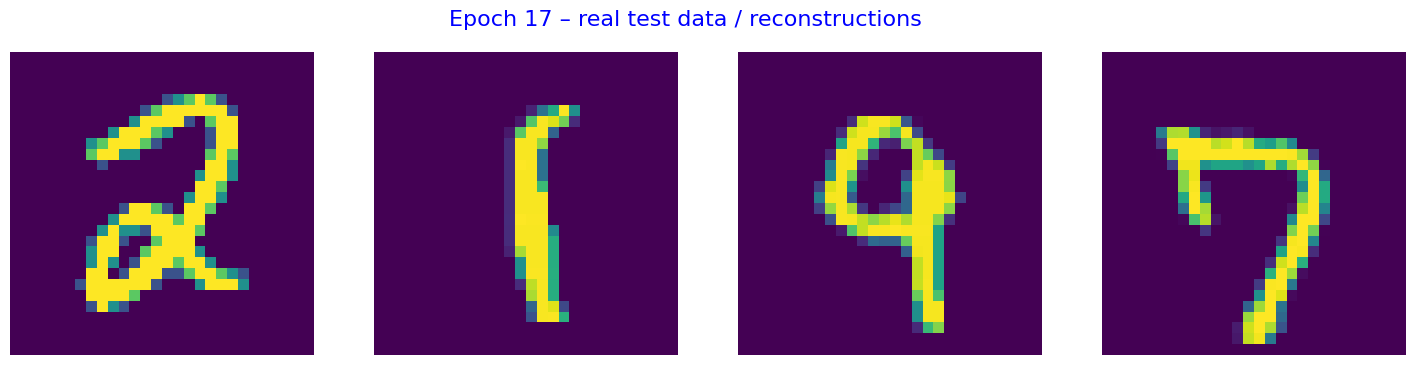

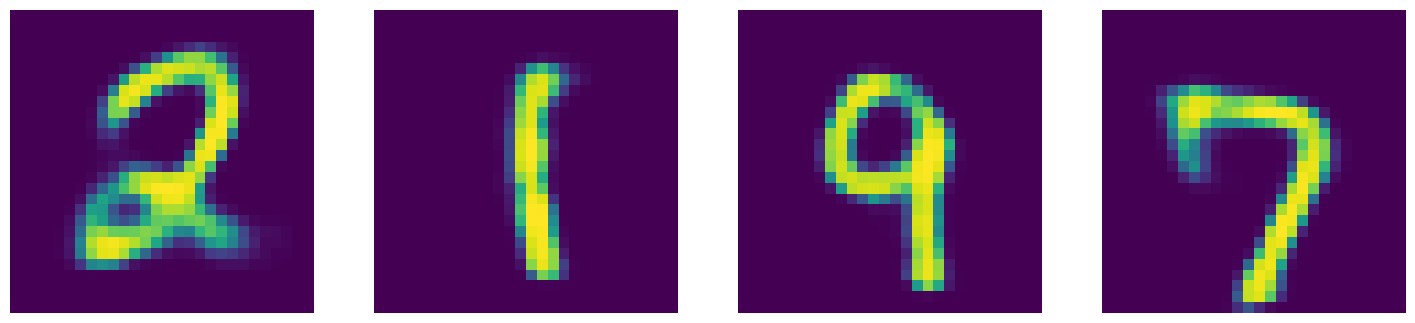

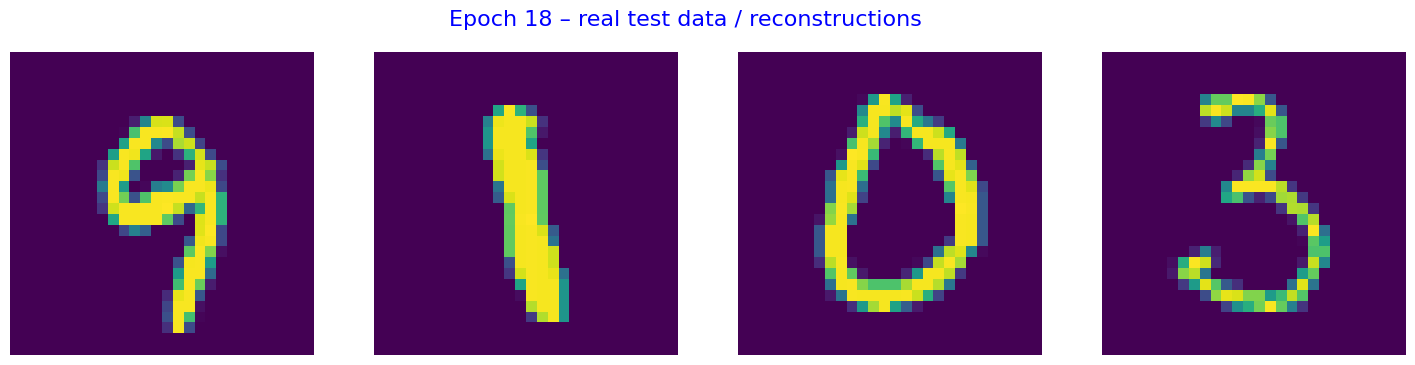

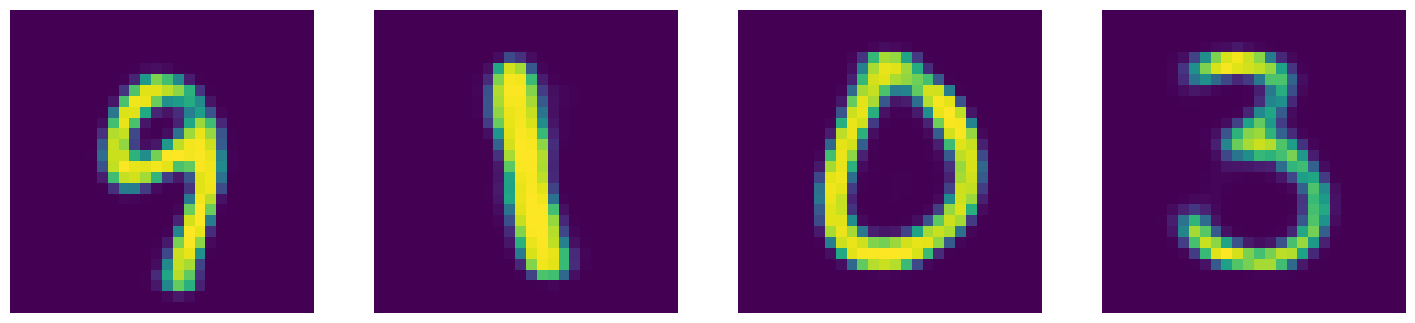

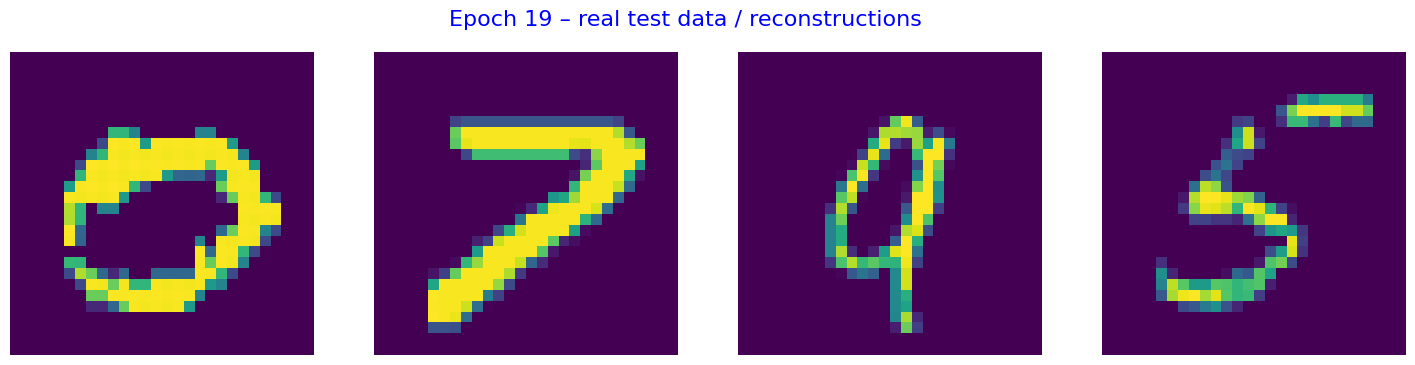

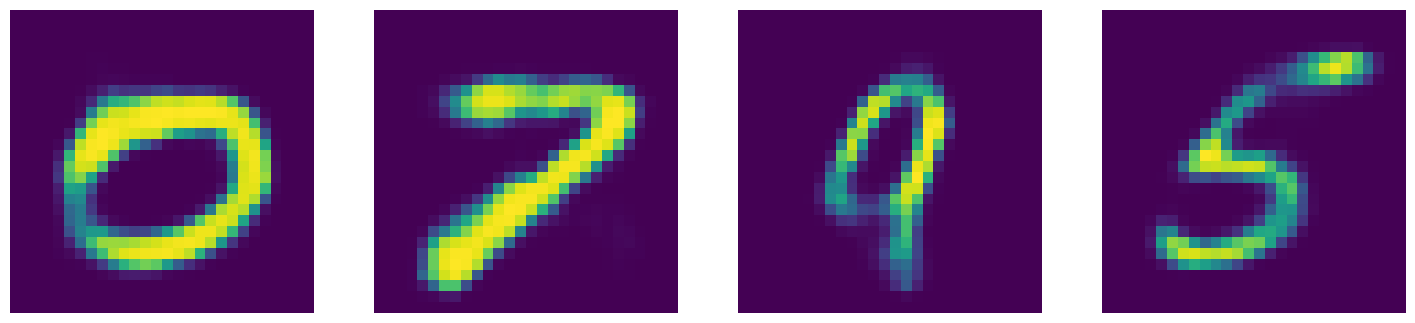

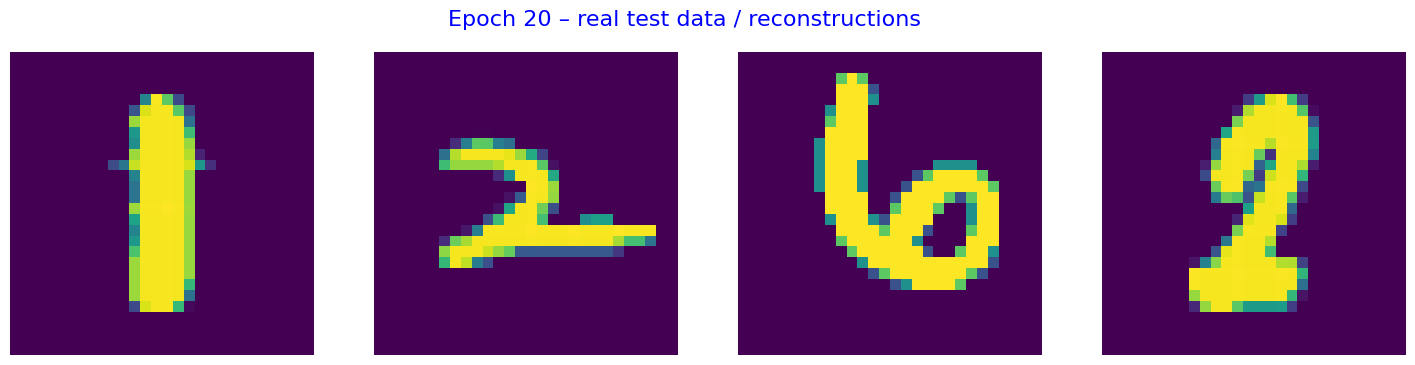

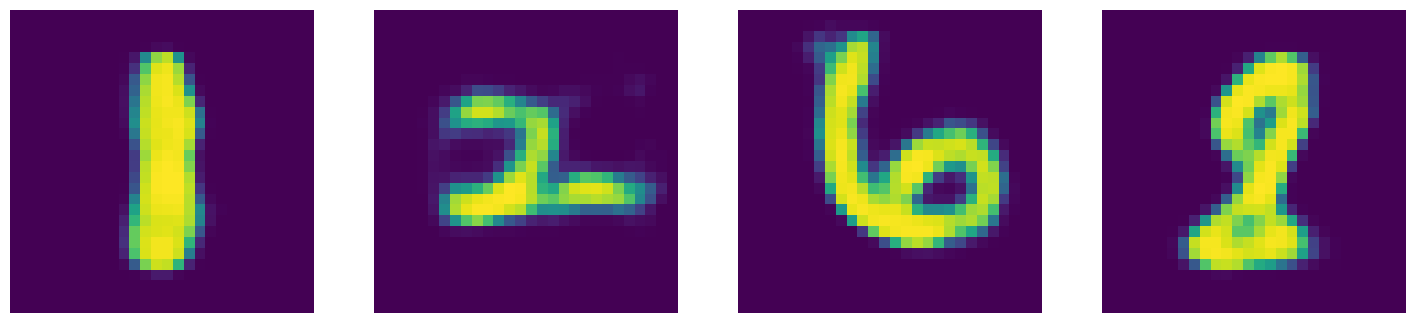

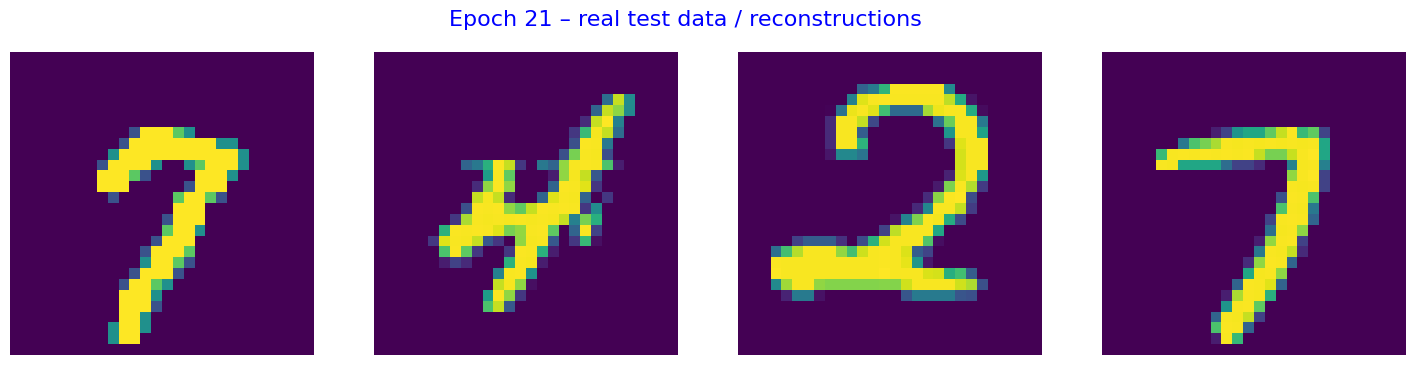

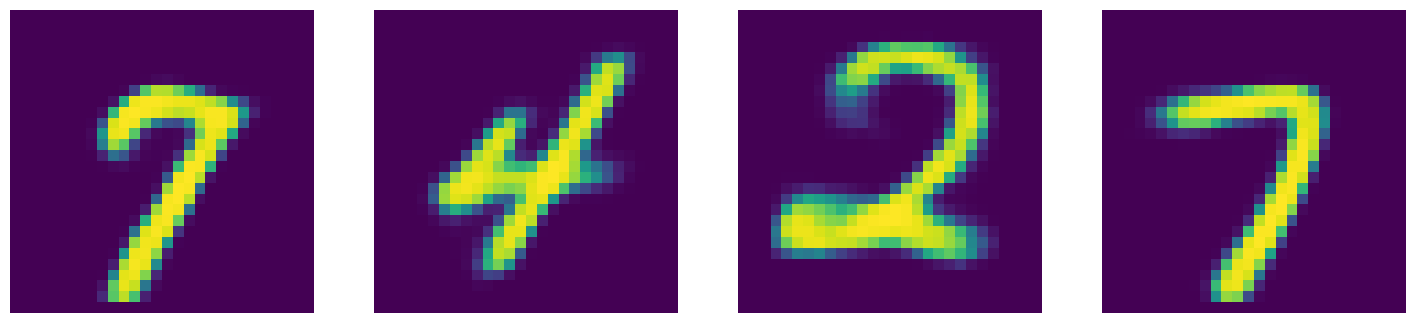

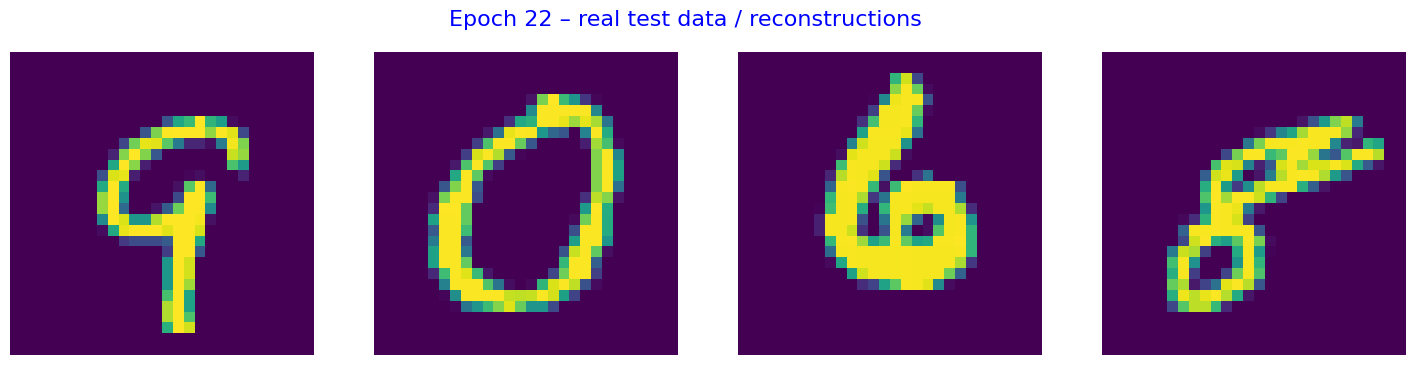

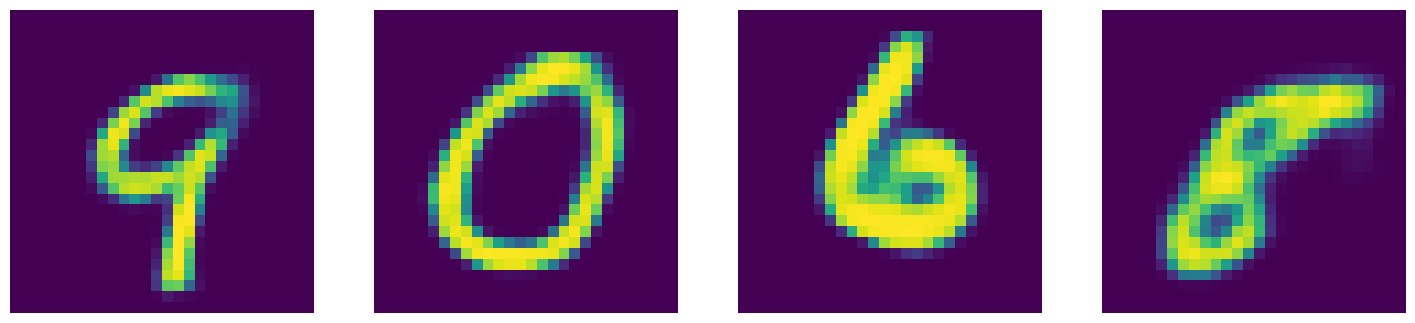

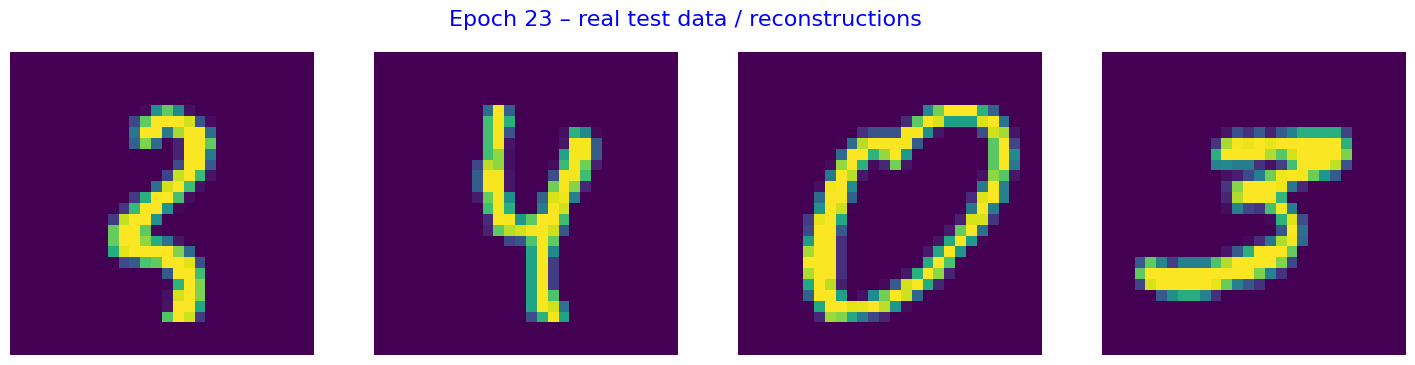

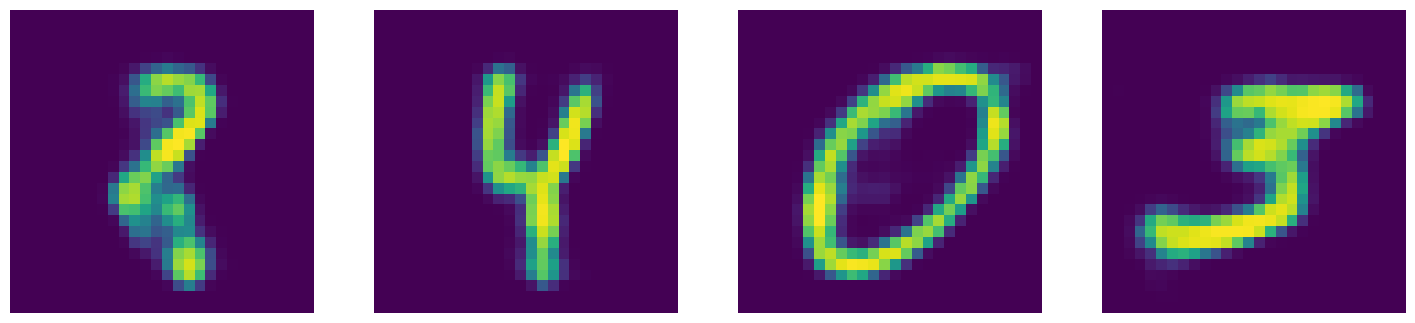

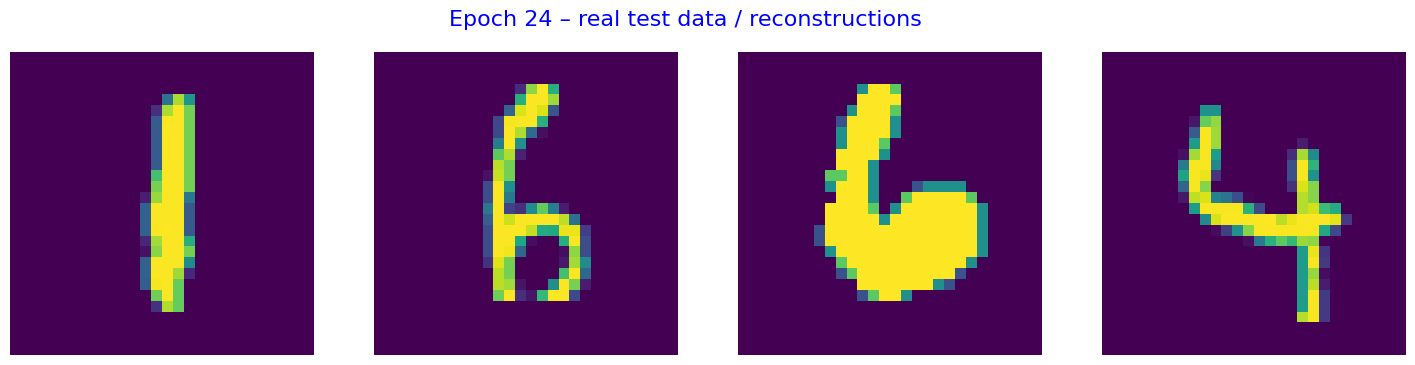

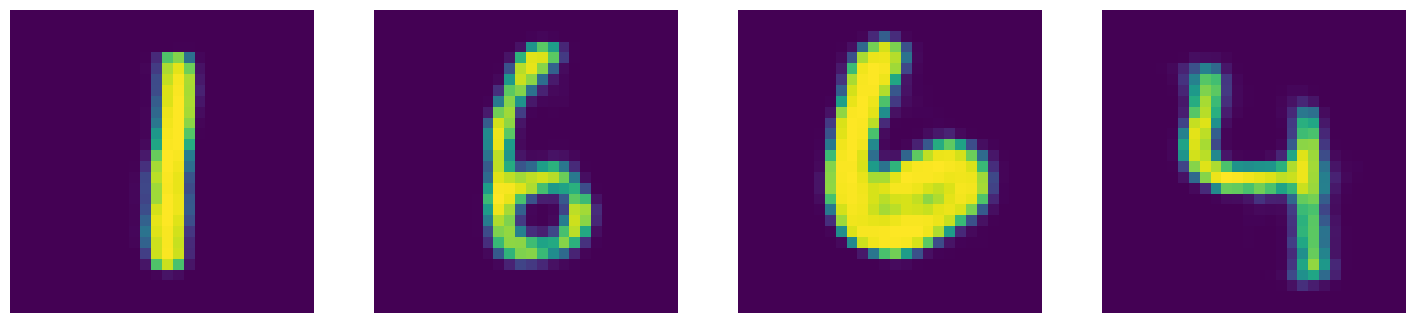

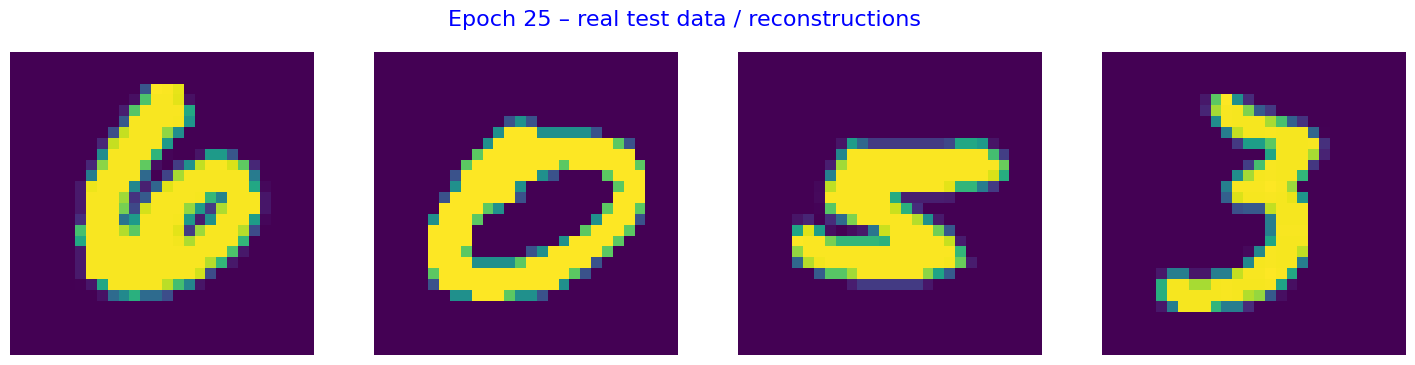

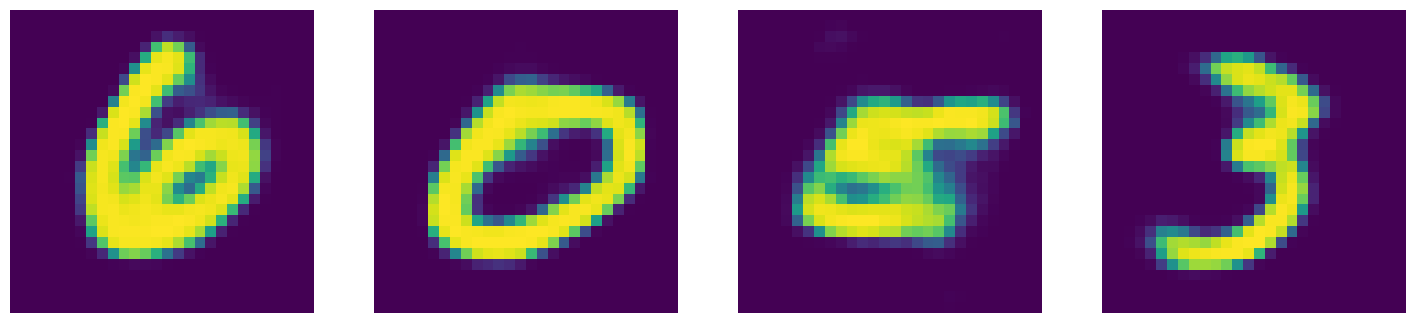

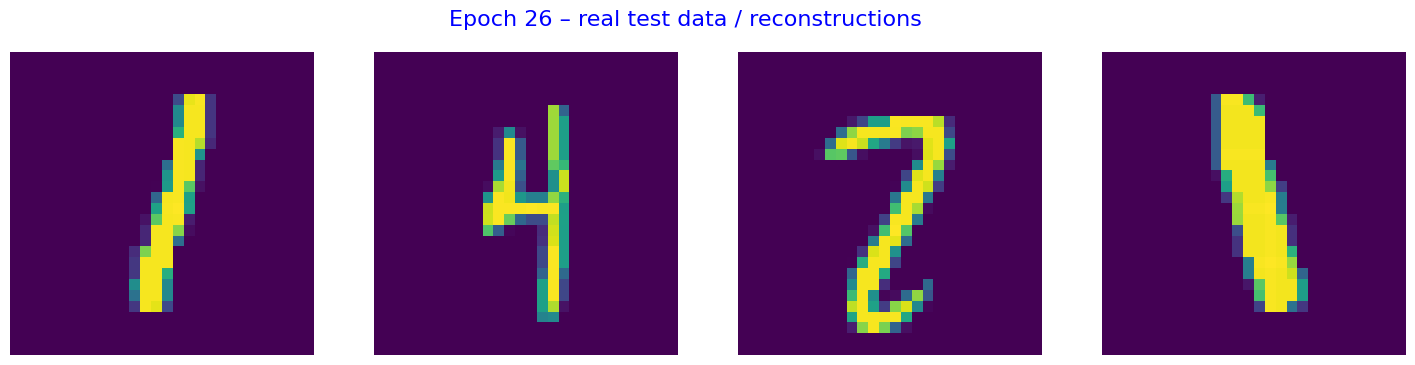

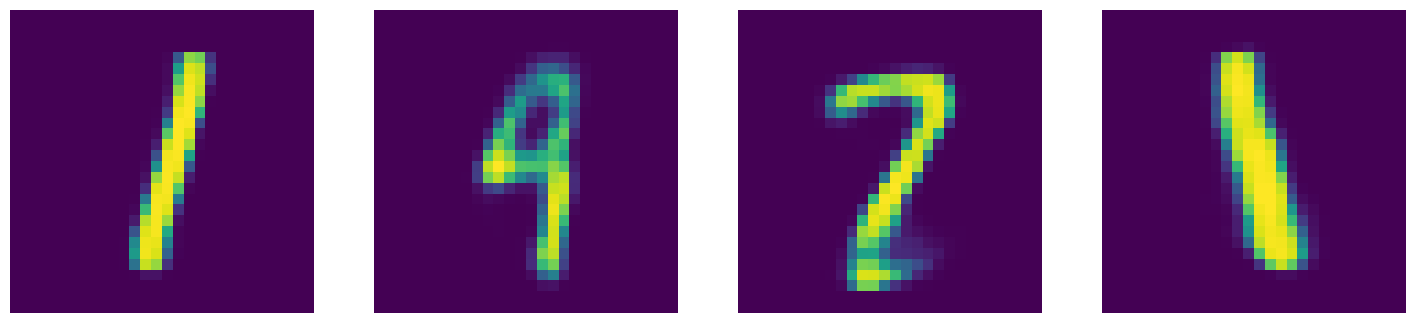

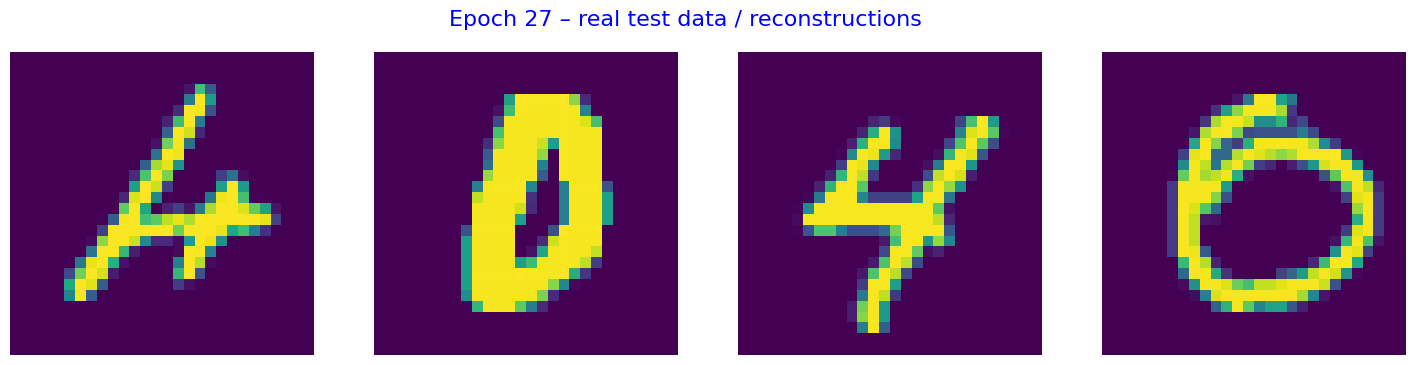

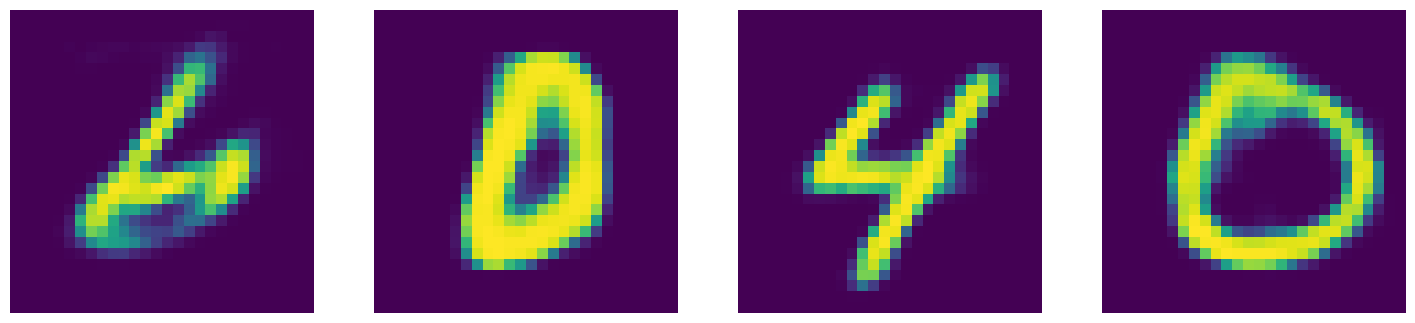

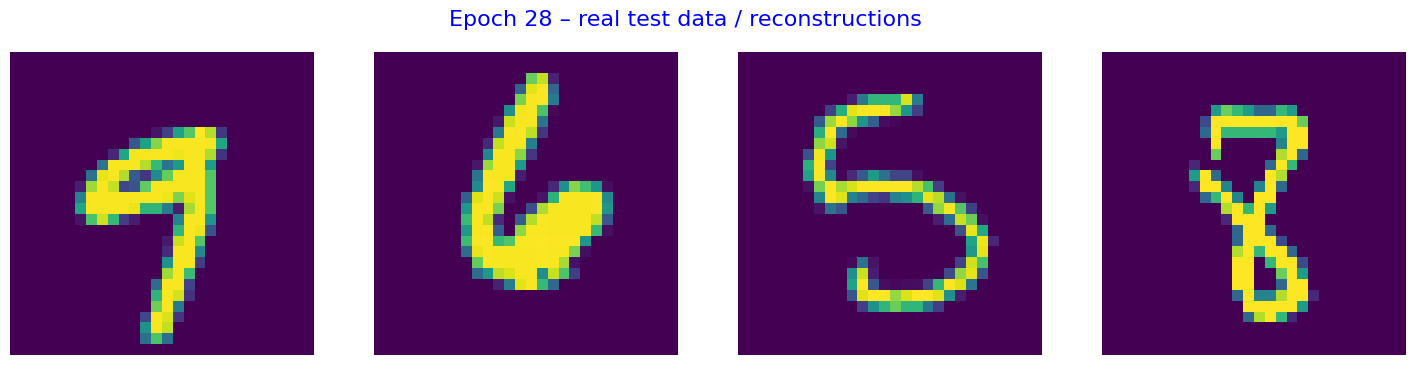

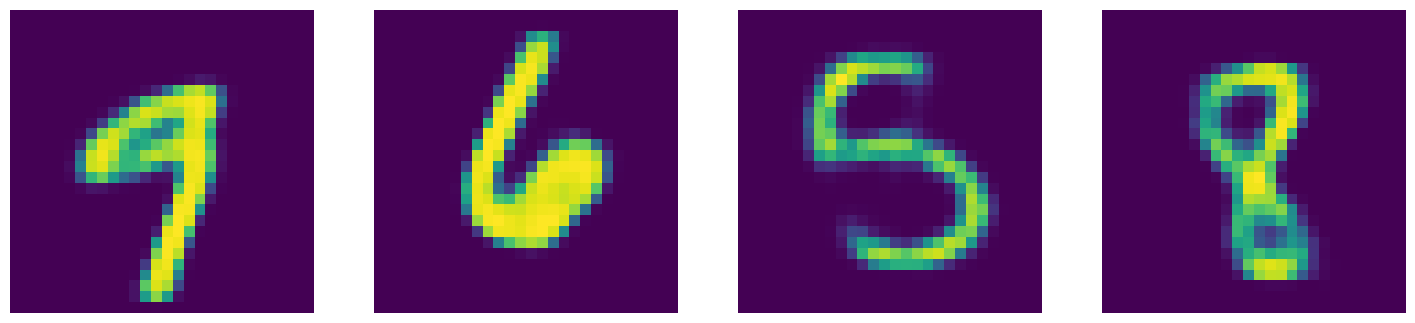

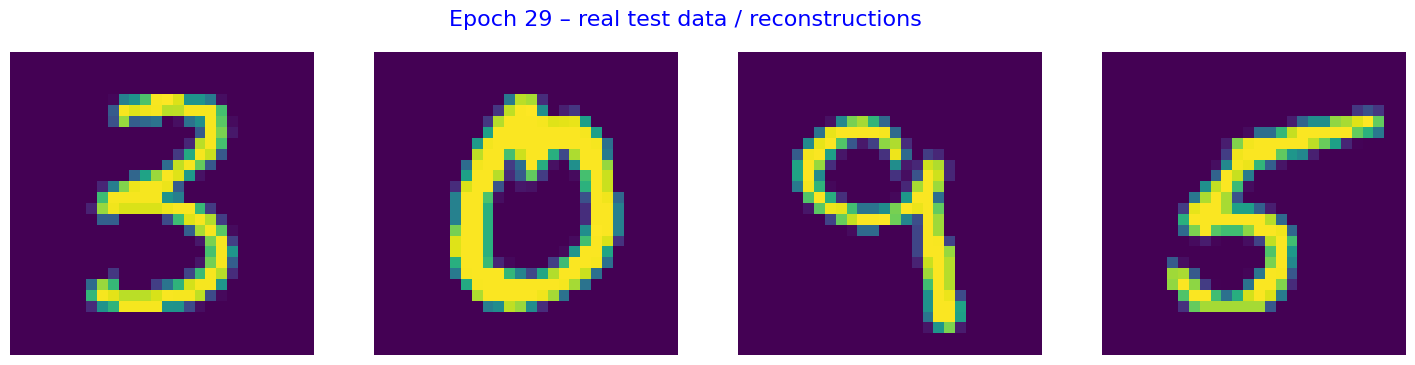

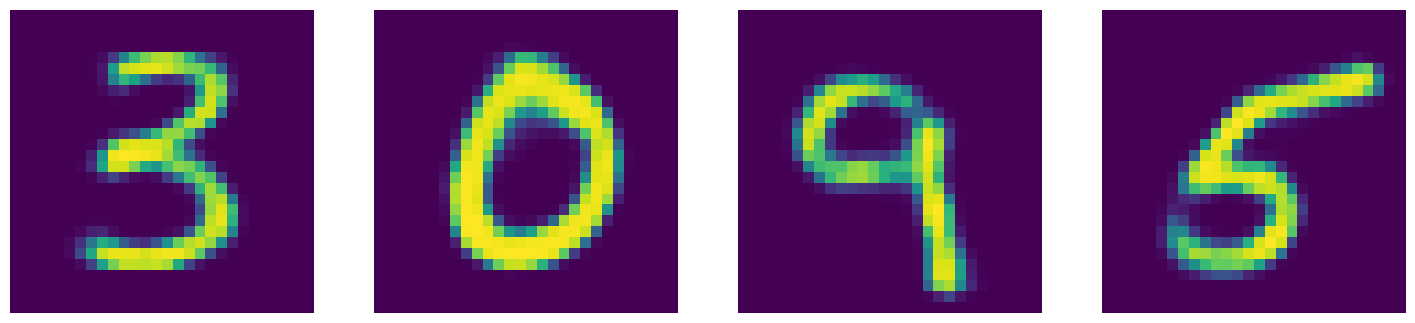

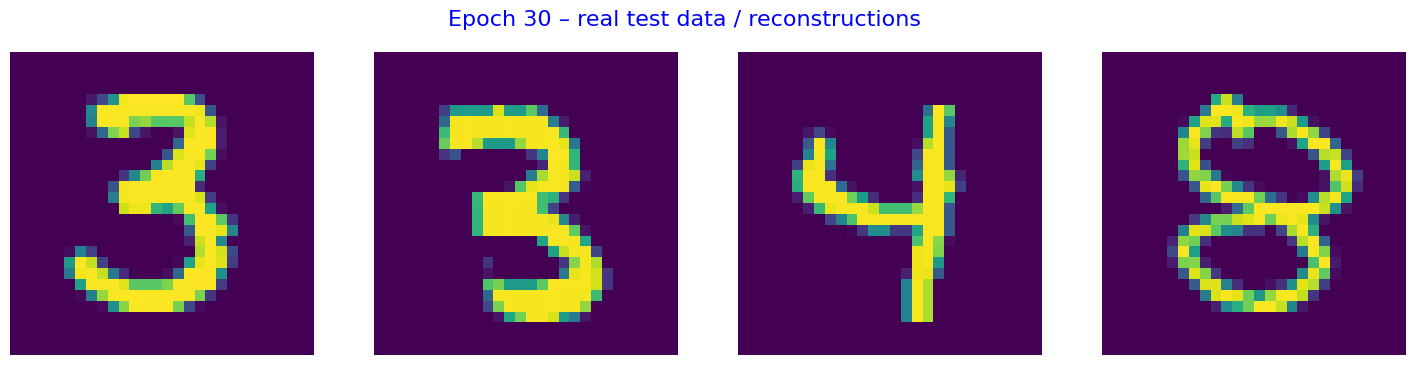

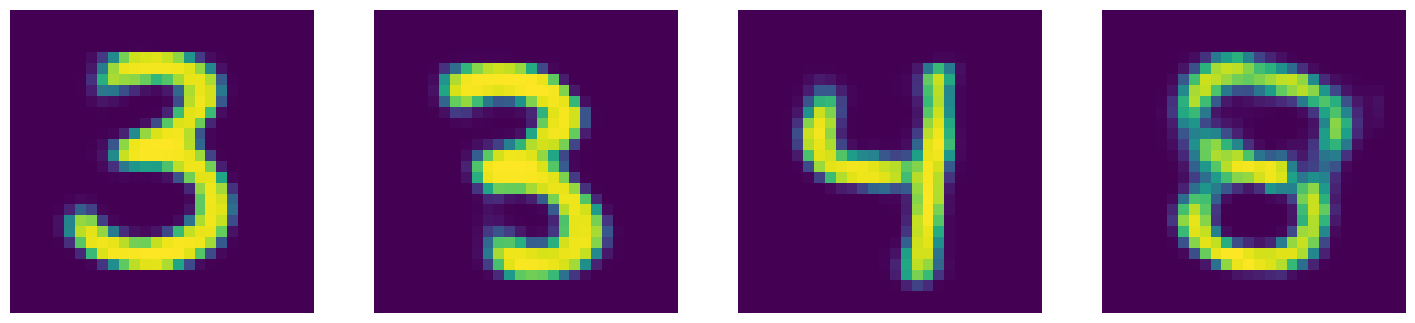

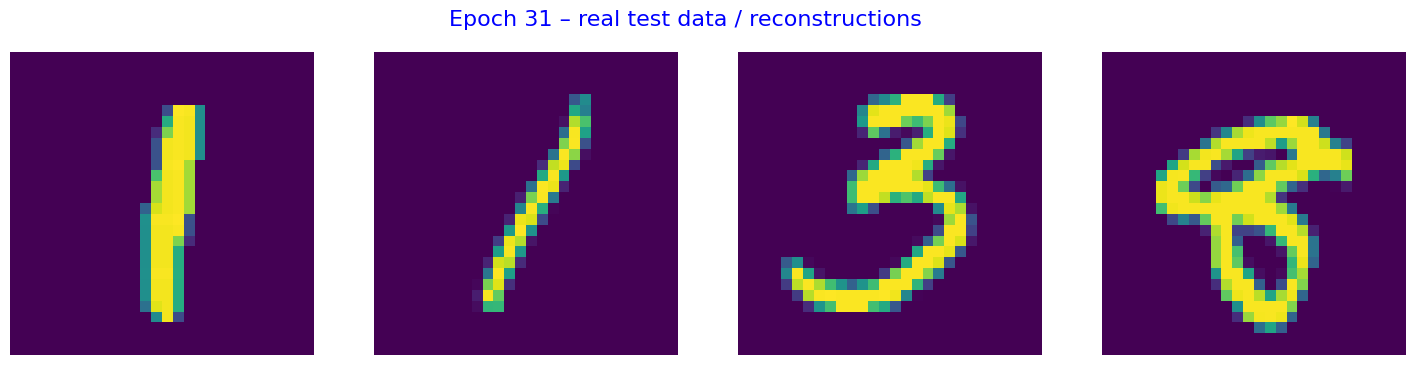

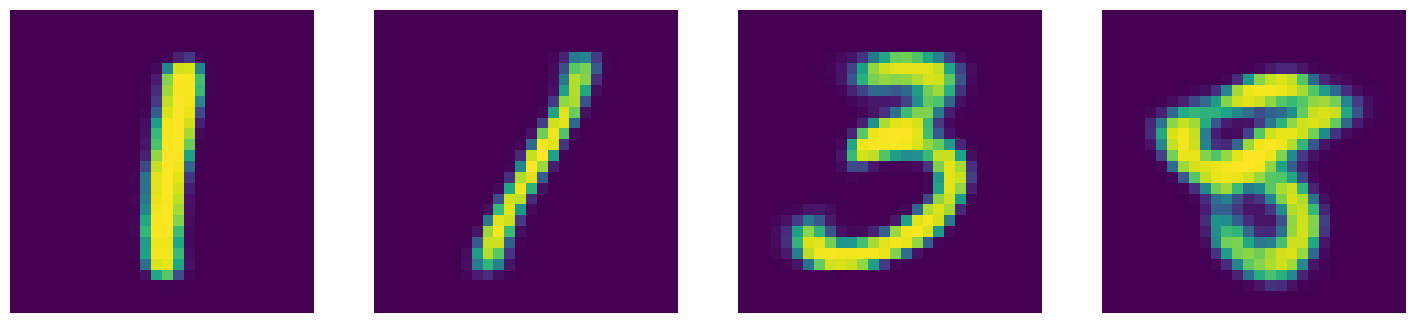

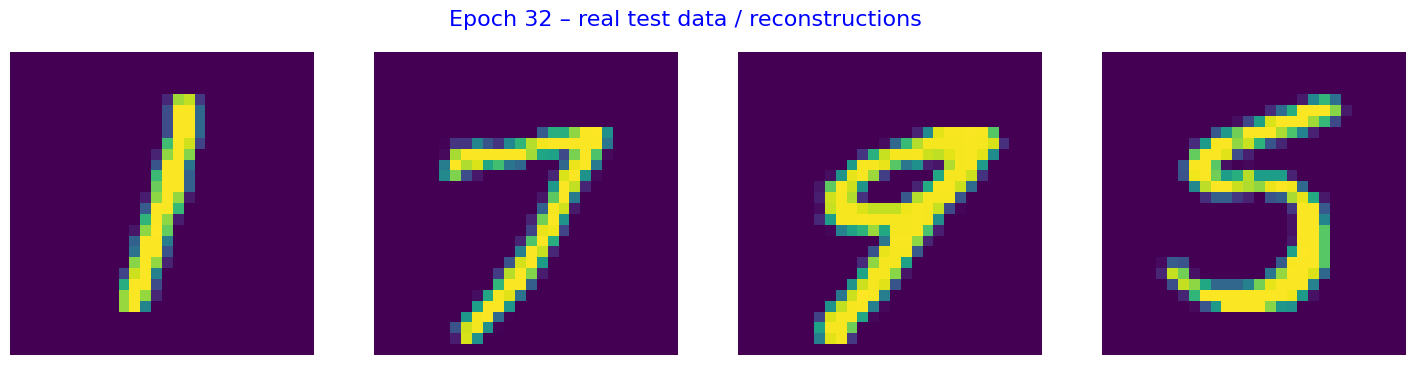

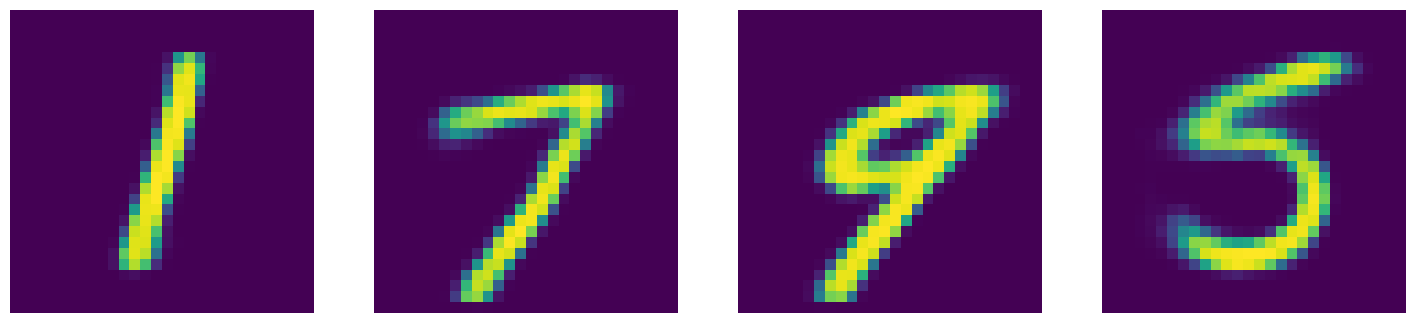

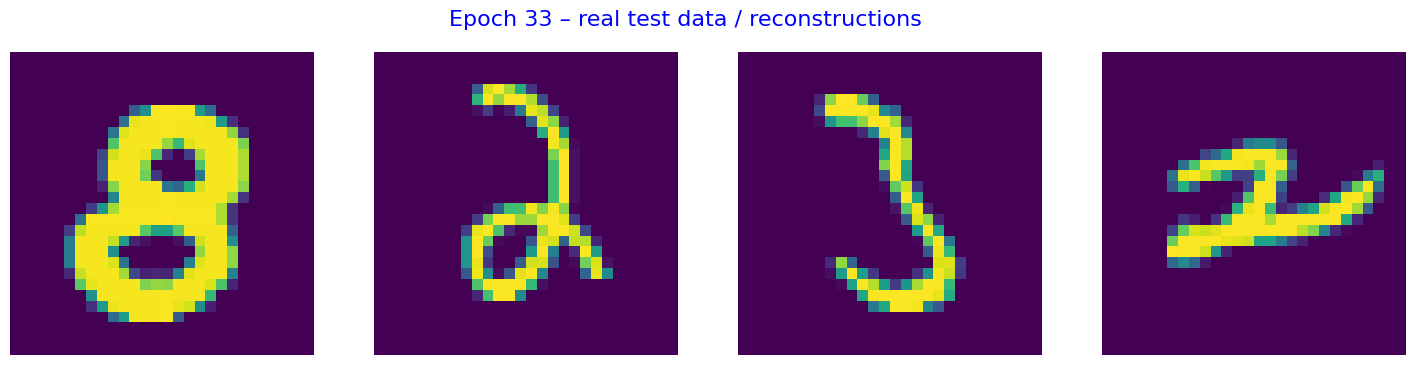

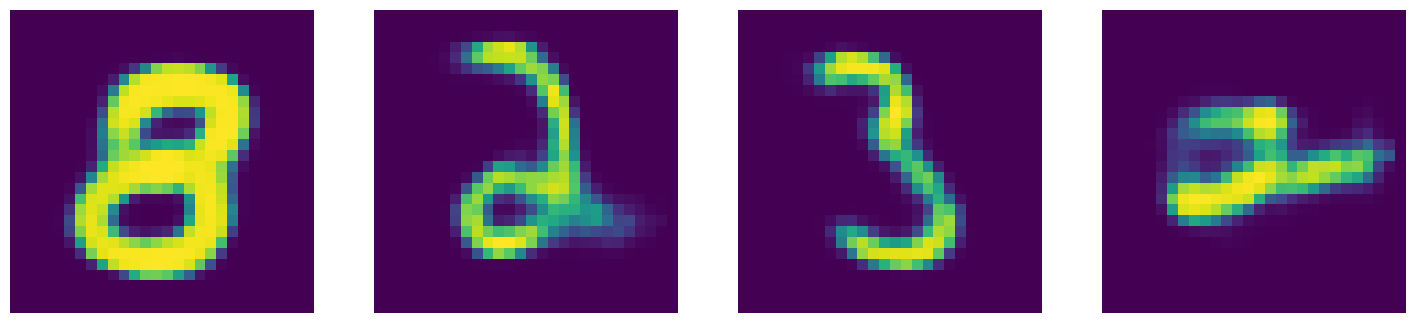

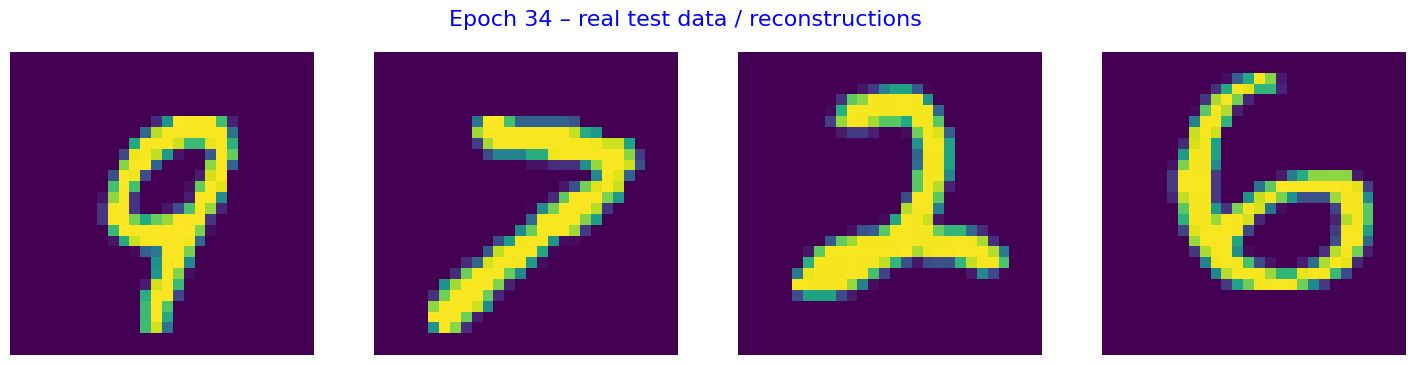

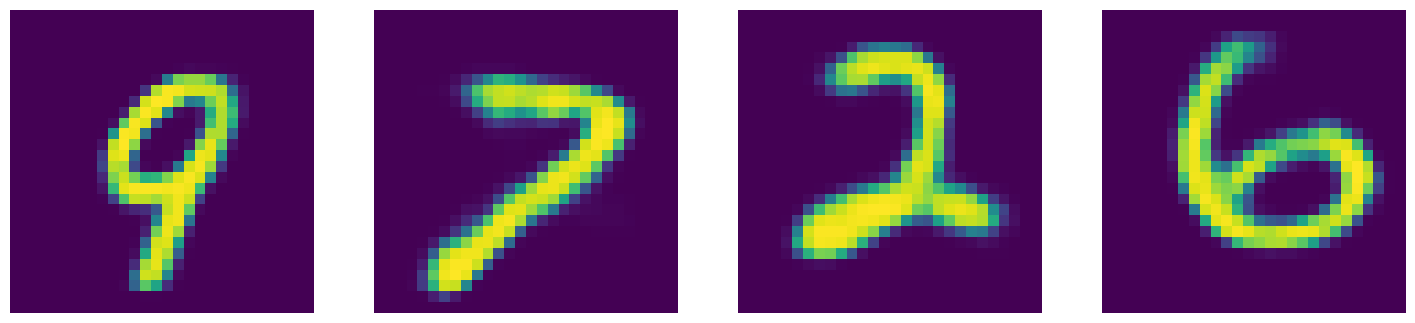

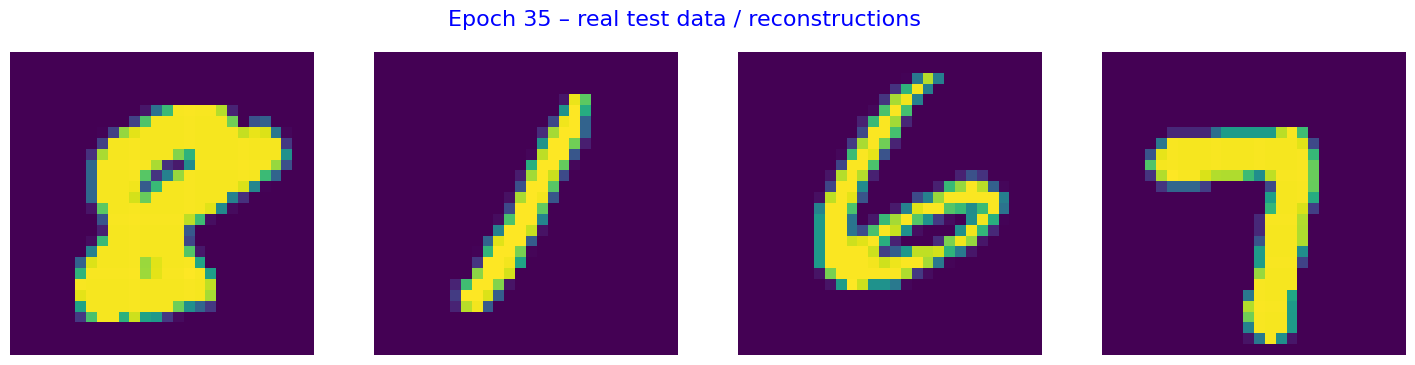

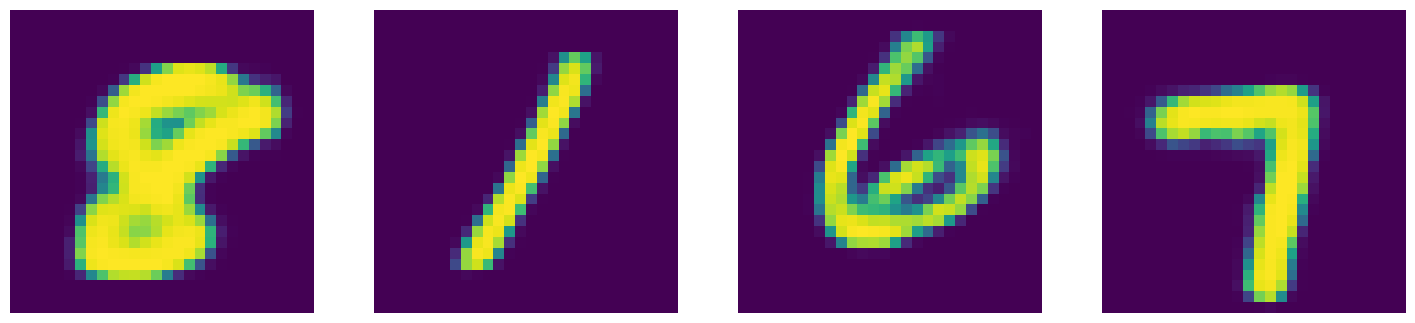

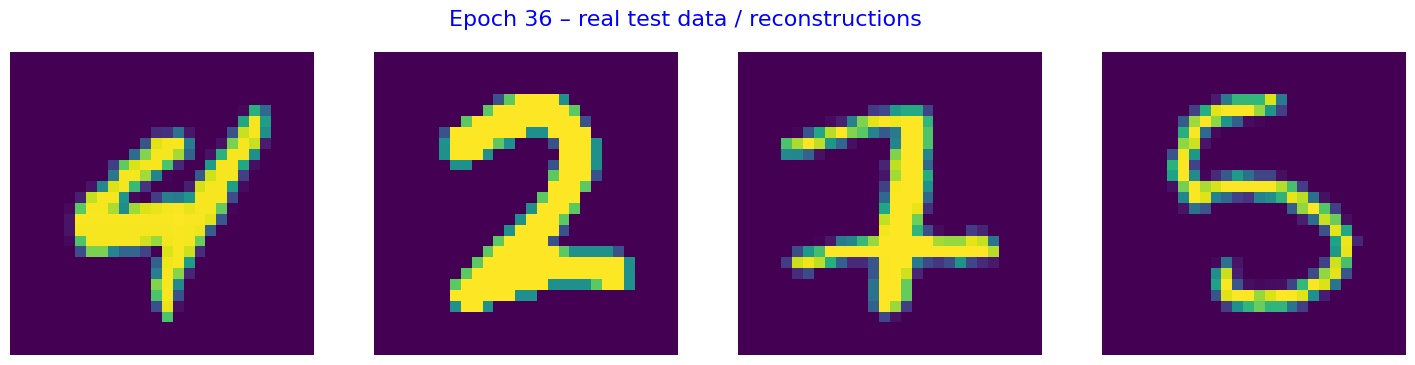

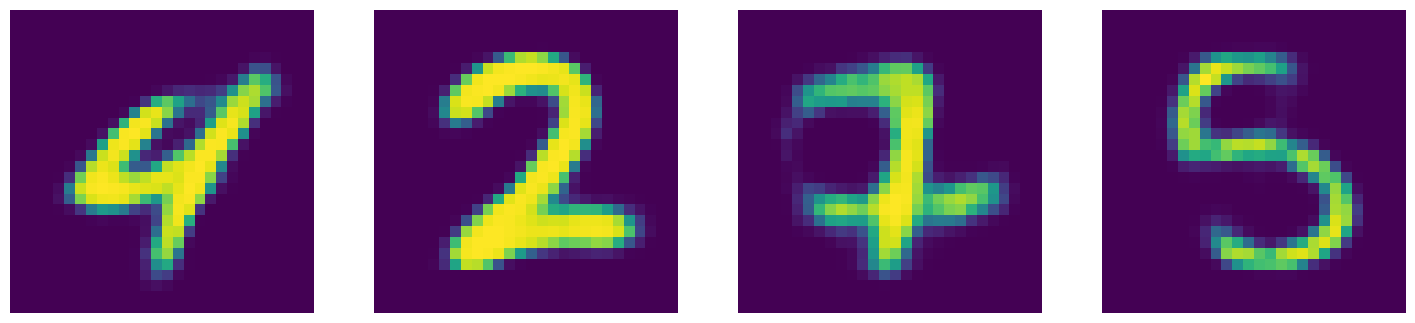

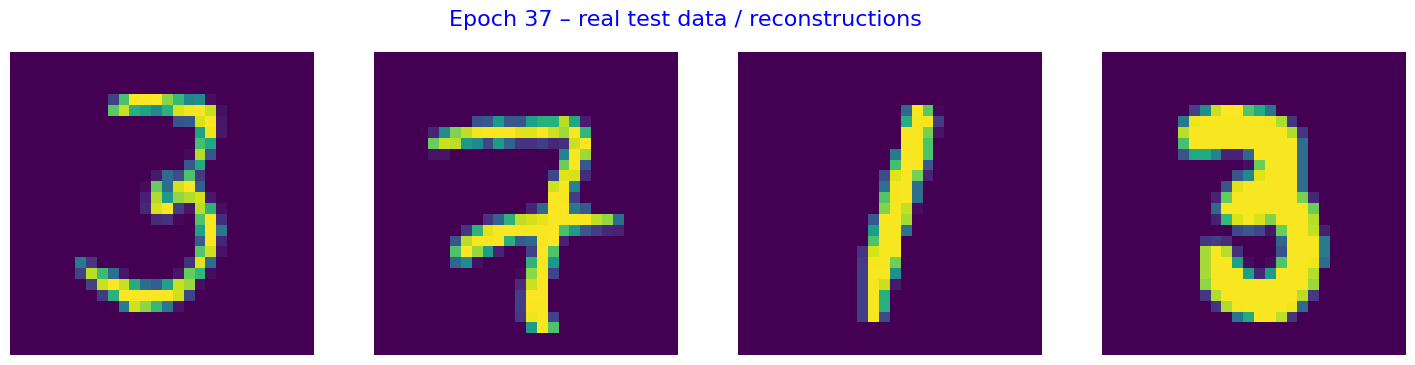

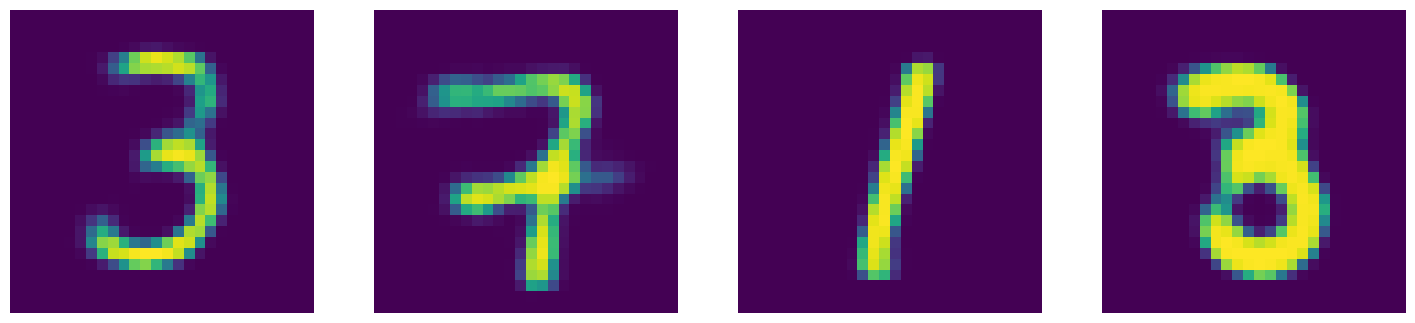

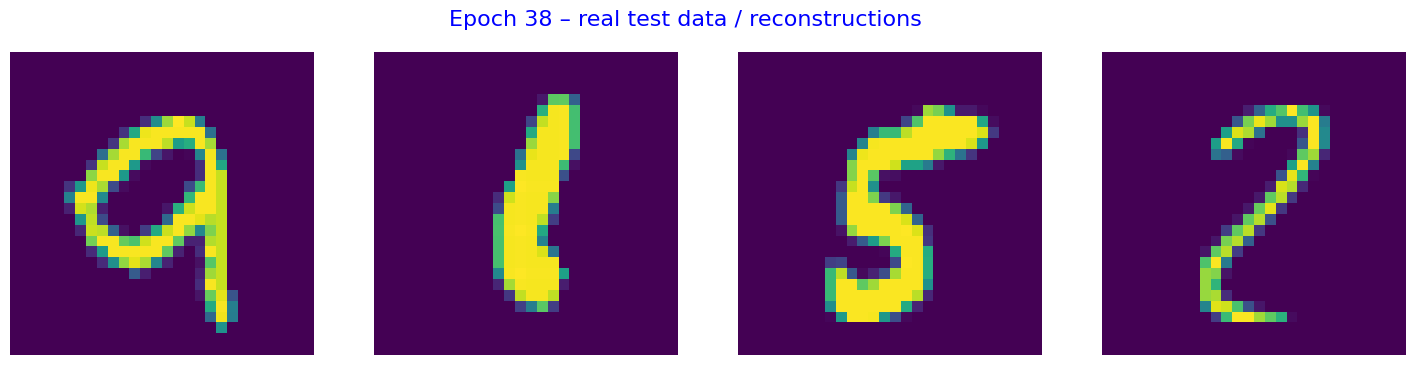

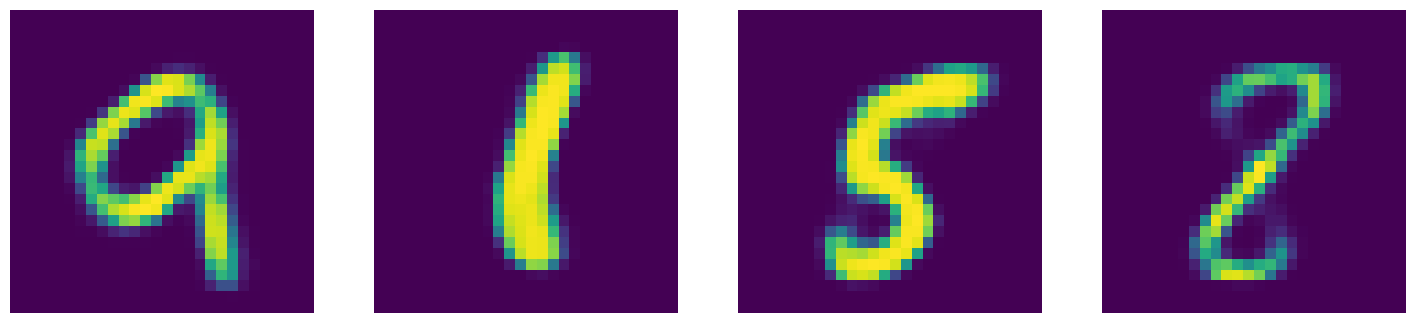

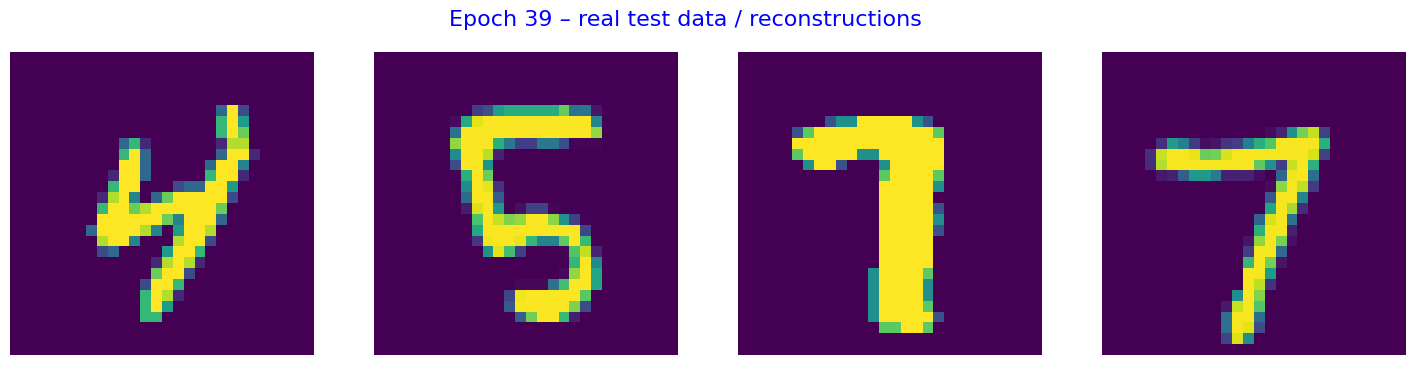

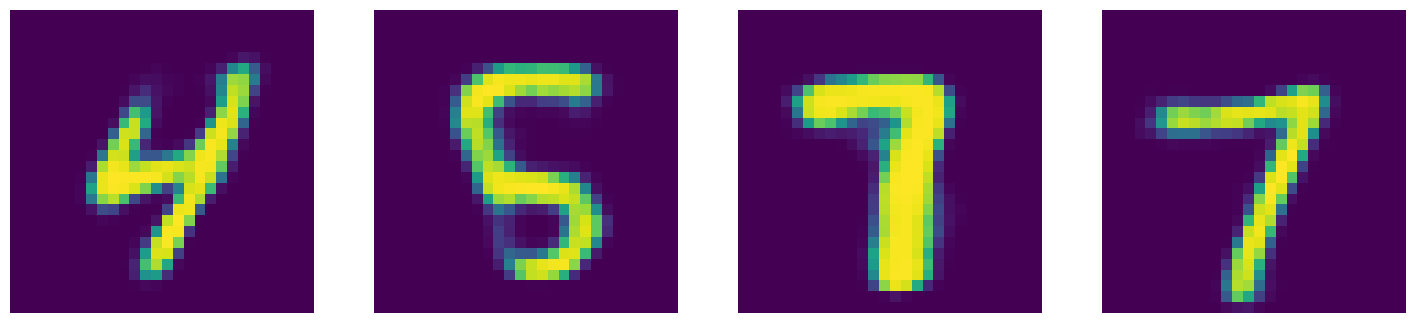

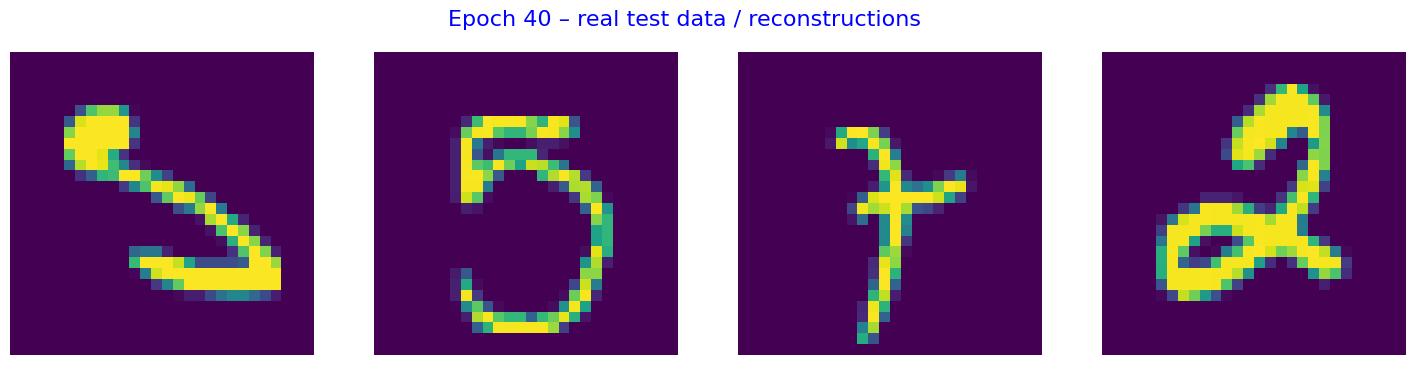

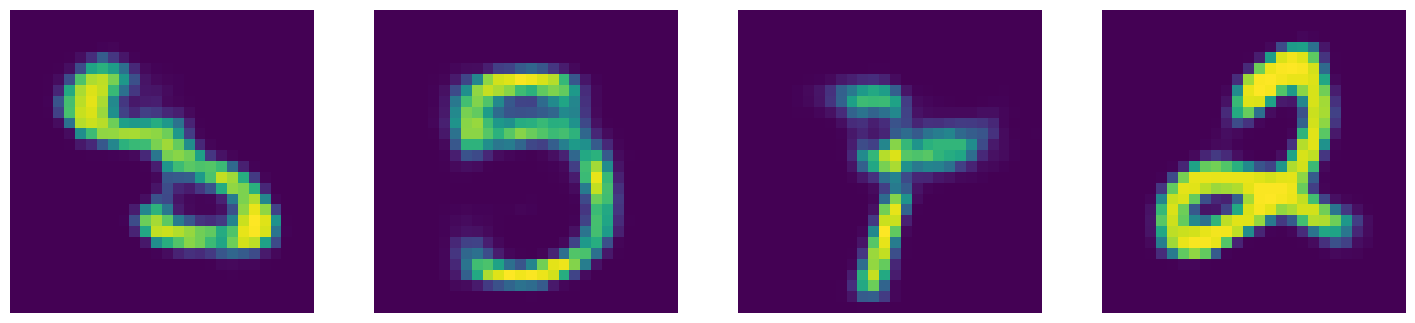

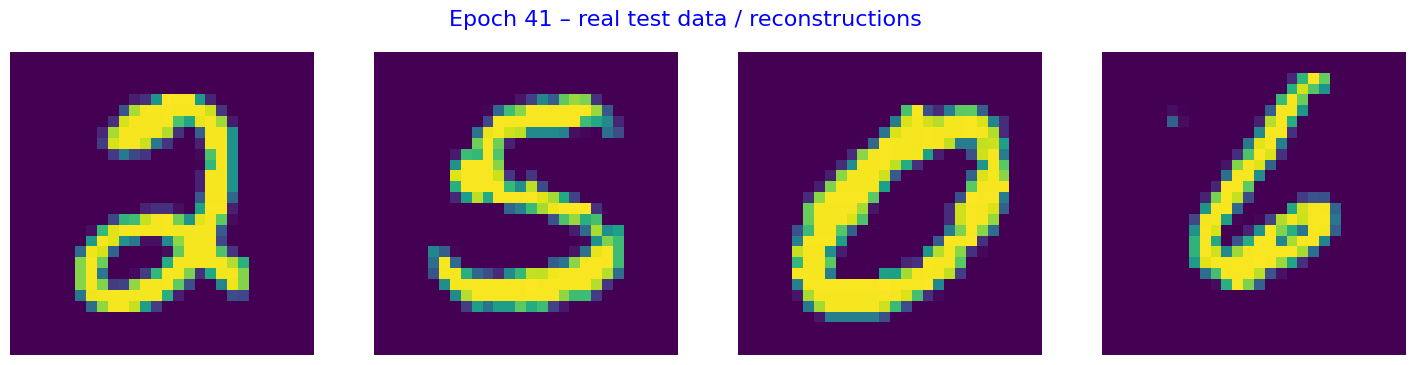

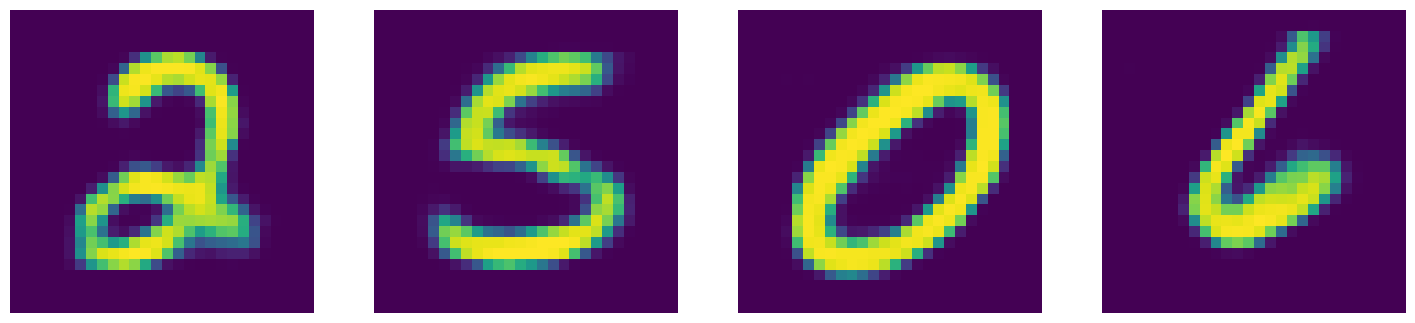

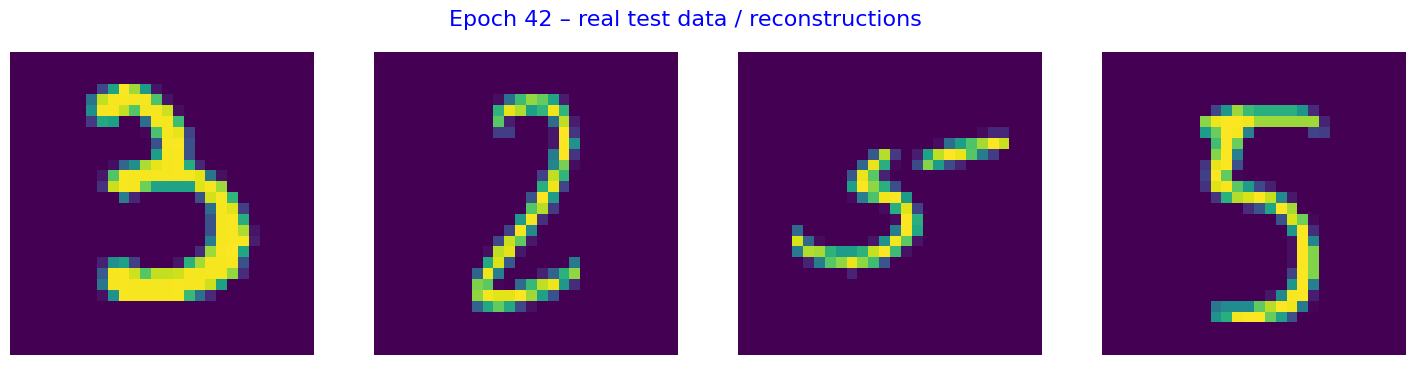

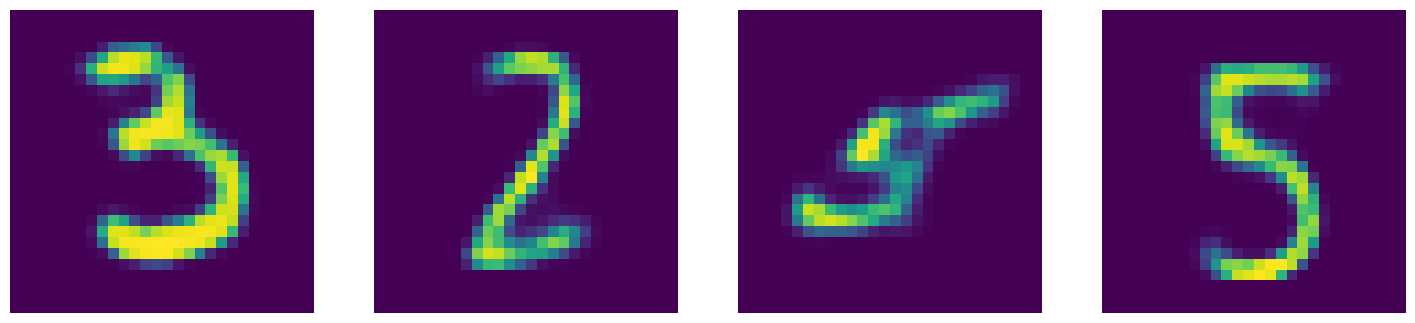

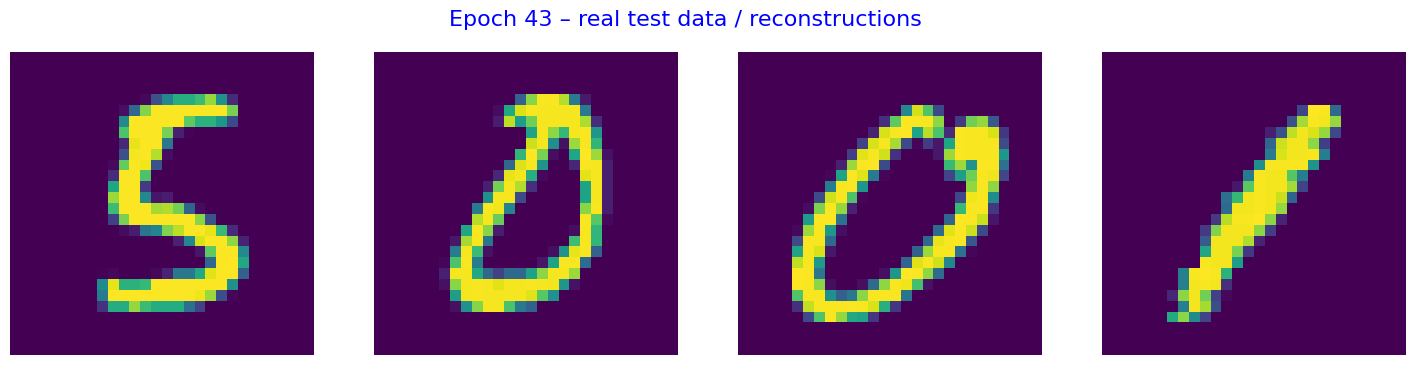

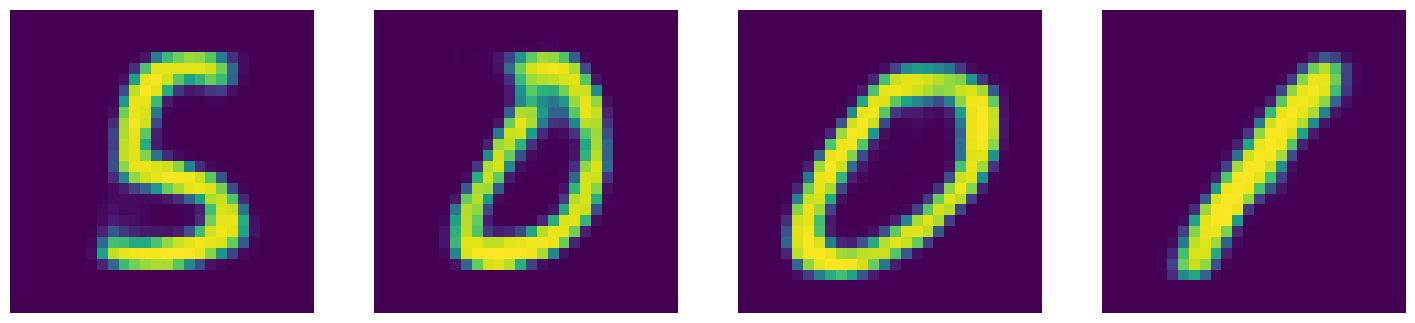

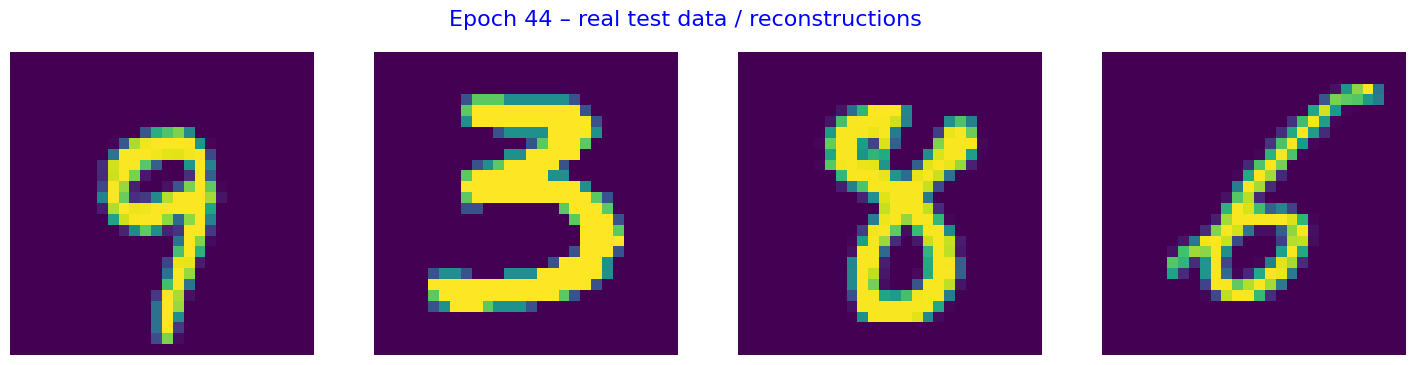

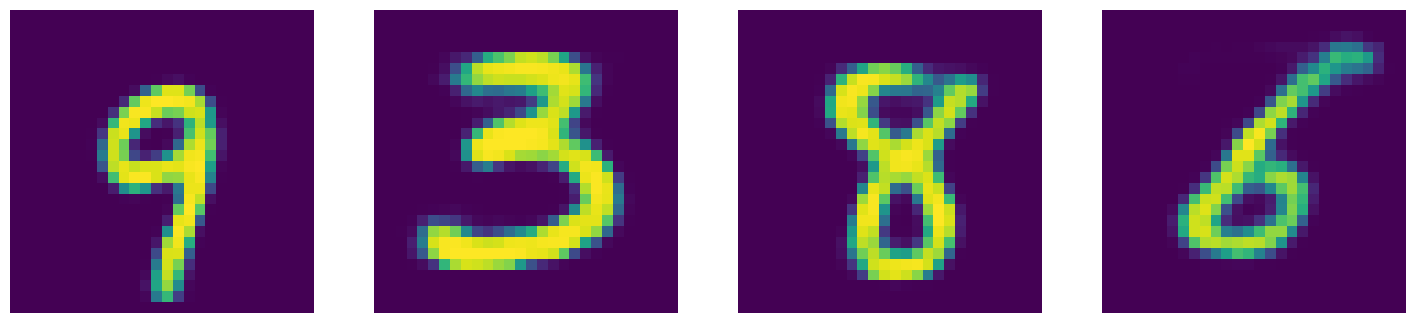

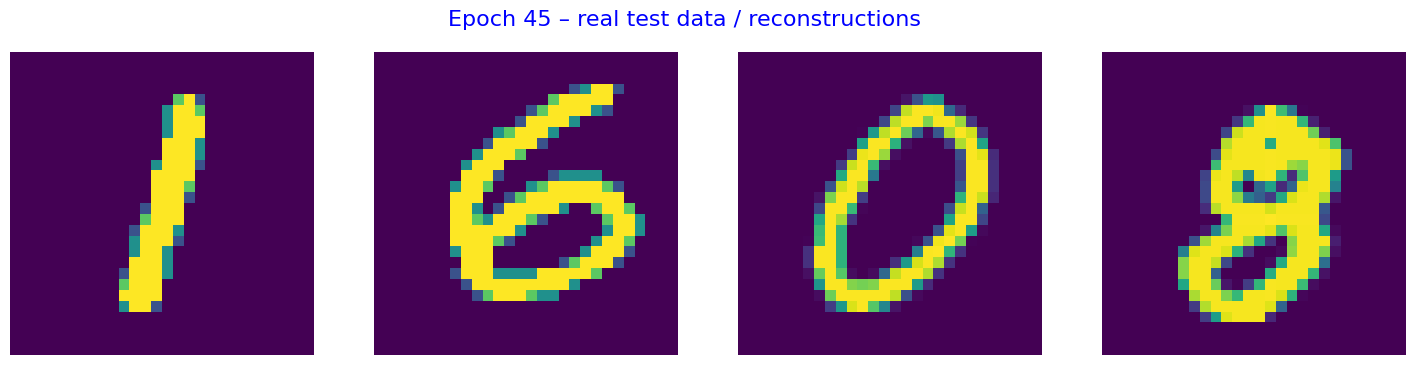

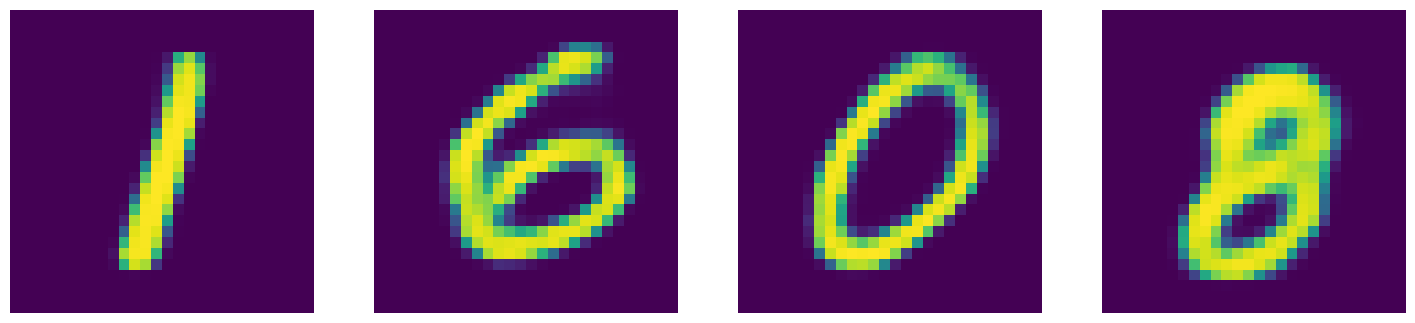

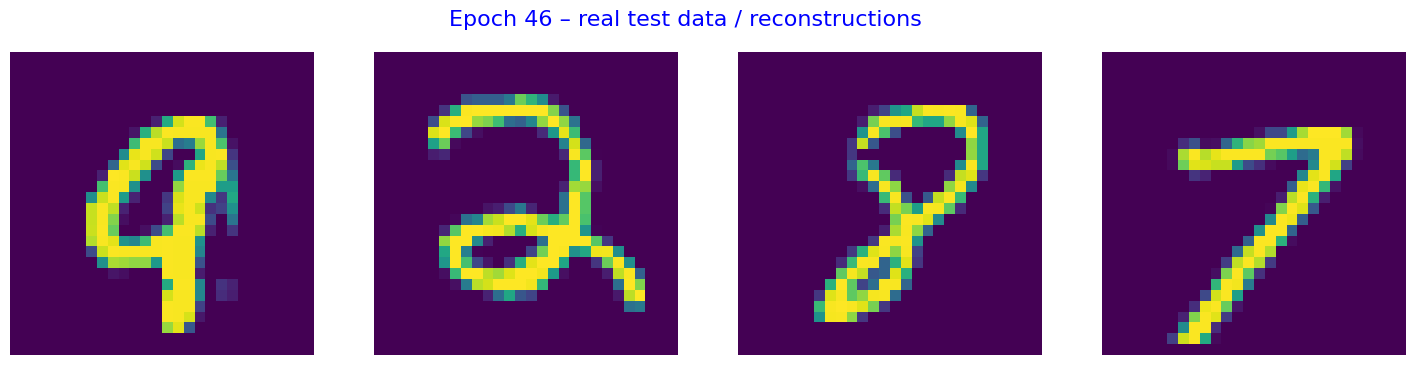

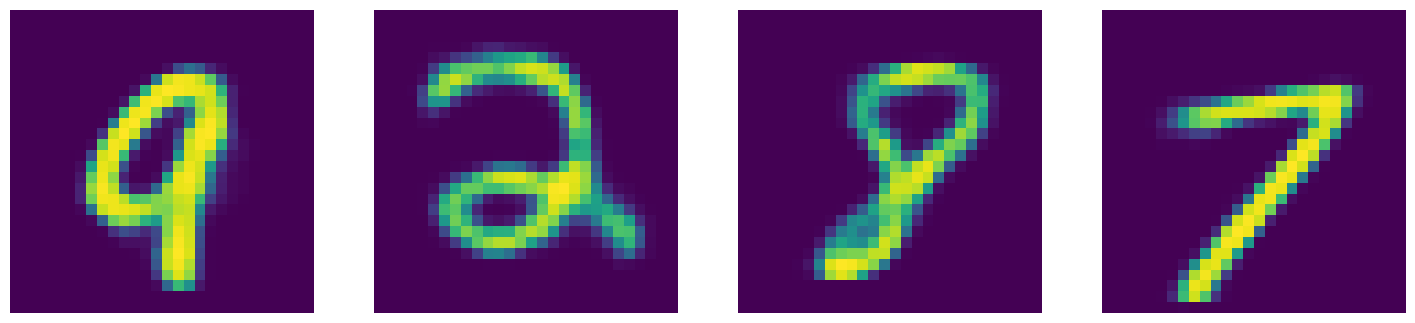

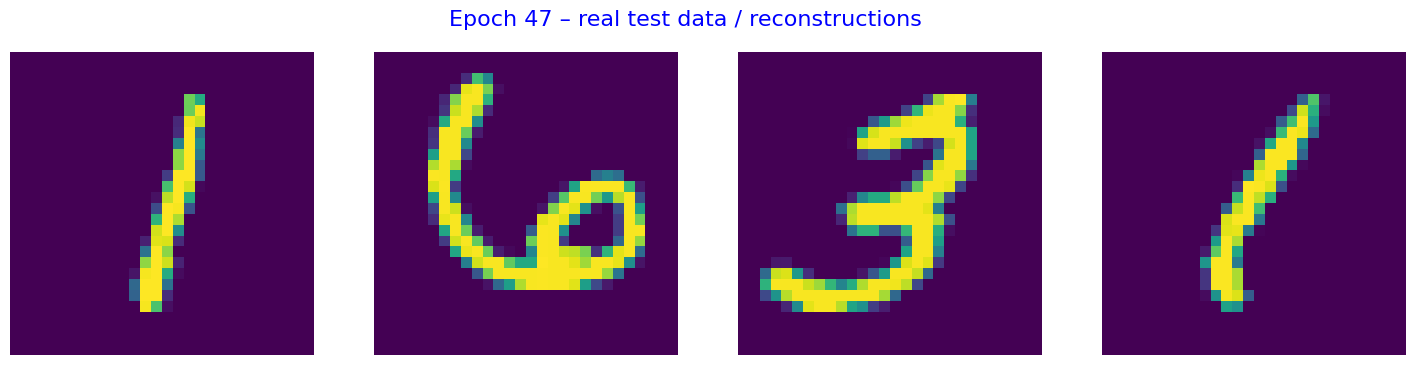

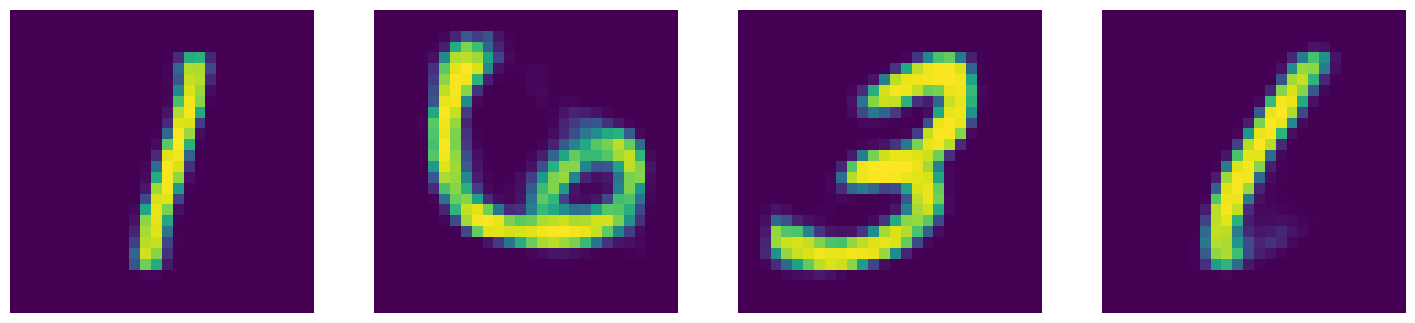

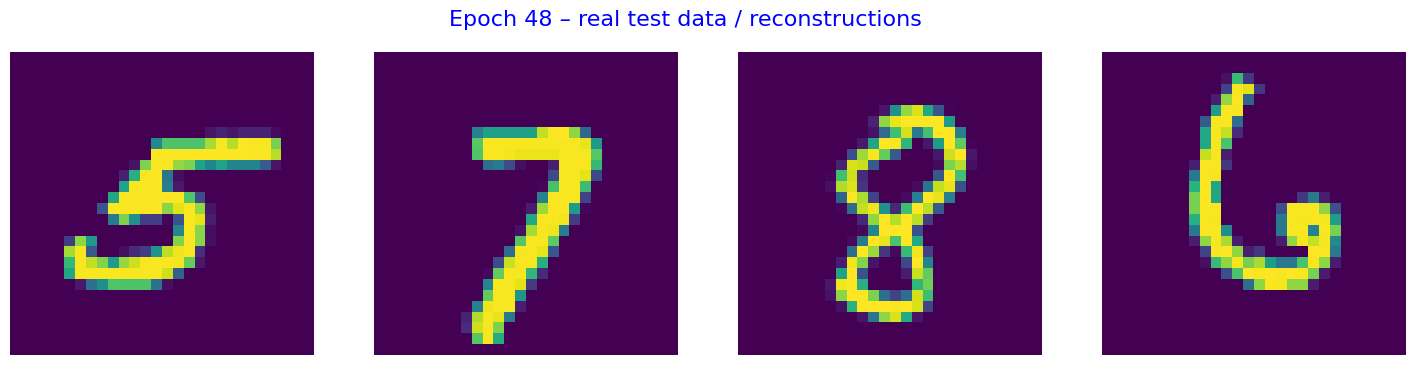

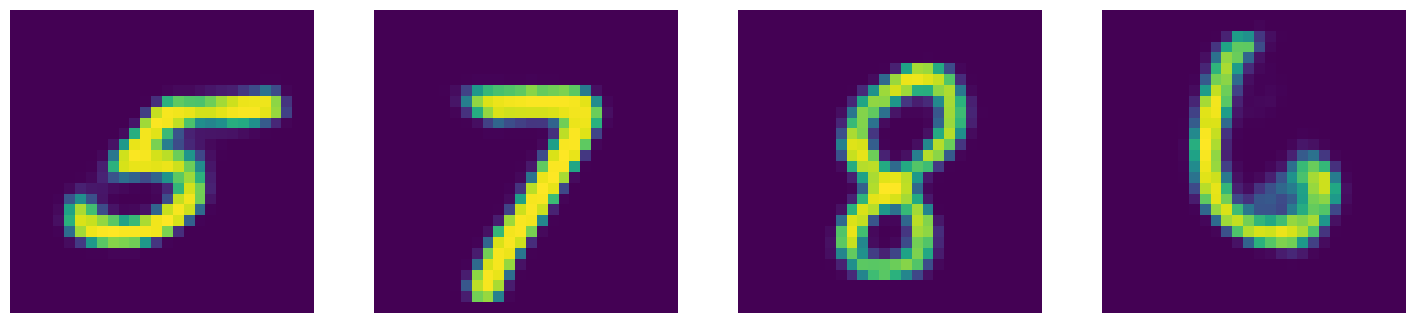

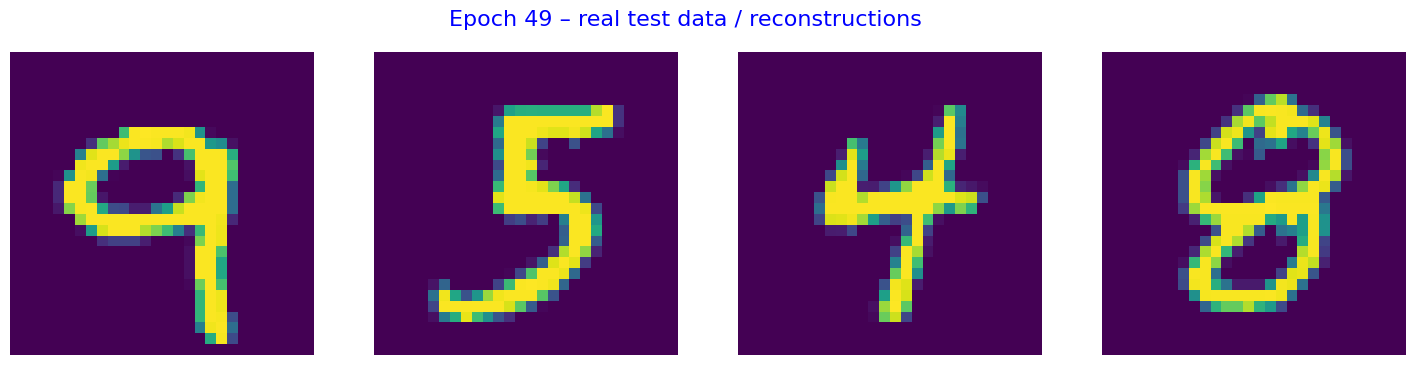

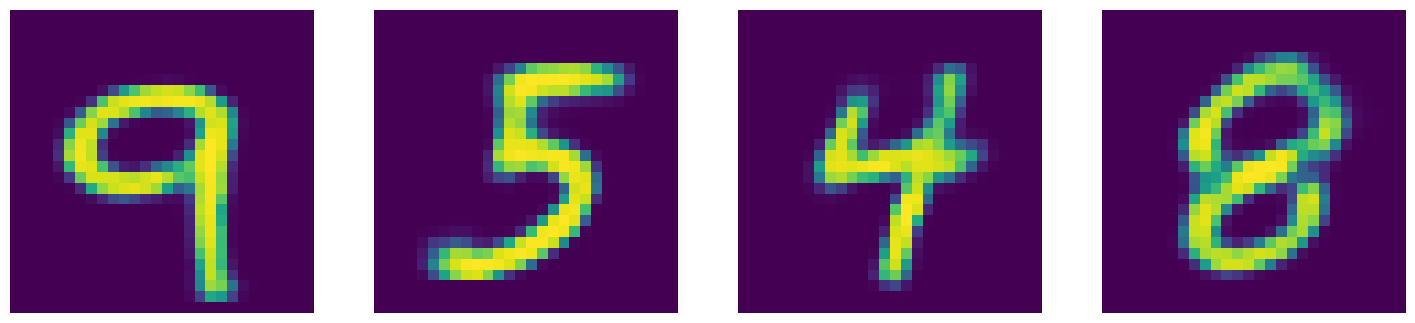

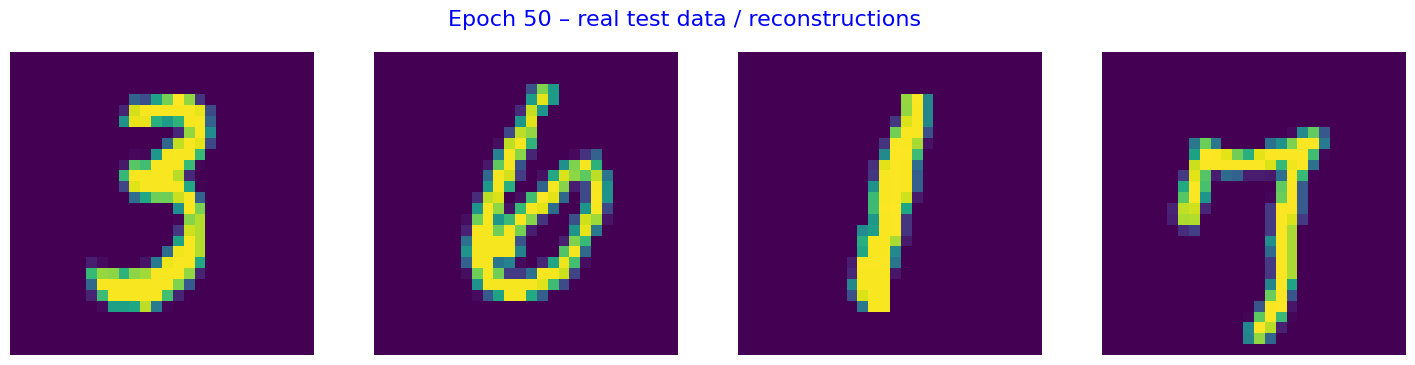

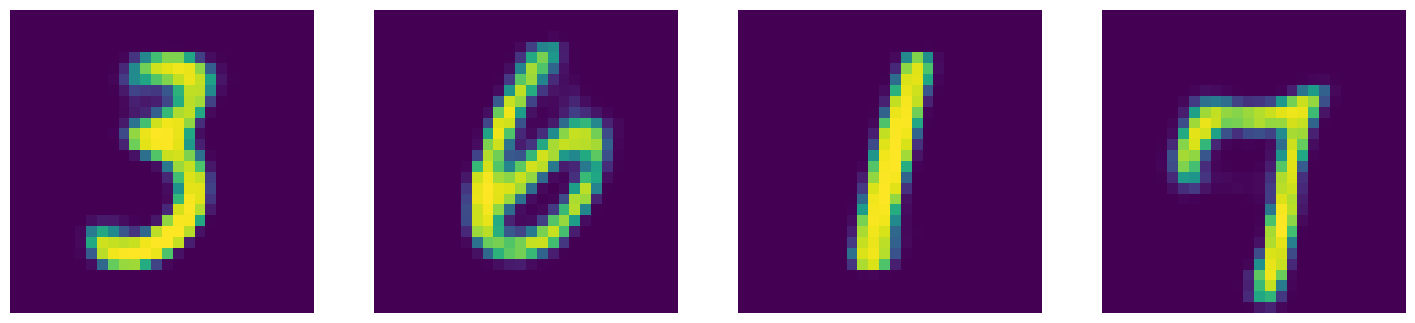

In [10]:
# Training and testing the VAE

EPOCHS = 50
codes = dict(μ=list(), log2=list(), y=list())

for epoch in tqdm(range(0, EPOCHS + 1)):
    # Training 
    if epoch > 0:
        model.train()
        train_loss = 0
        for x, _ in train_dataloader:
            x = x.to(device)
            #=======================forward====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            #=====================back propagation ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # ========================== LOG=======================
        print(f"====> Epoch : {epoch} Average loss = {train_loss/len(train_dataloader.dataset):.4f}")

        
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_dataloader:
            x = x.to(device)
            # ======================= forward =======================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar)
            # ==================== log ==============================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # =================================== log =======================
    codes['μ'].append(torch.cat(means))
    codes['log2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_dataloader.dataset)
    print(f"========> Test set loss : {test_loss:.4f}")
    display_image(x, x_hat, 1, f'Epoch {epoch}')

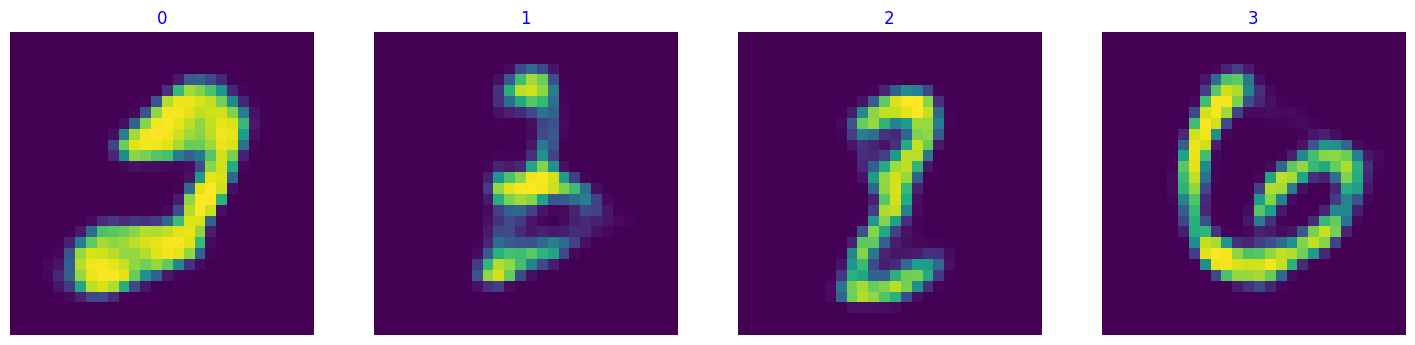

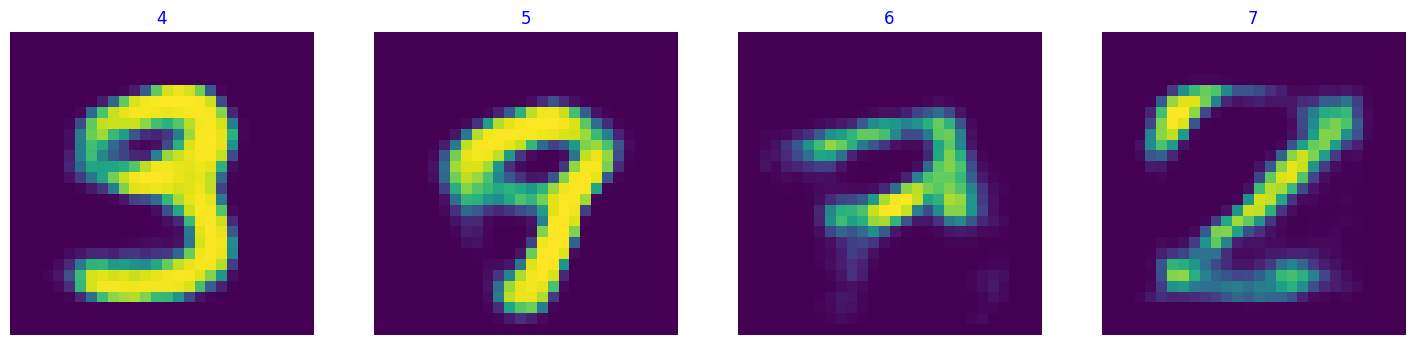

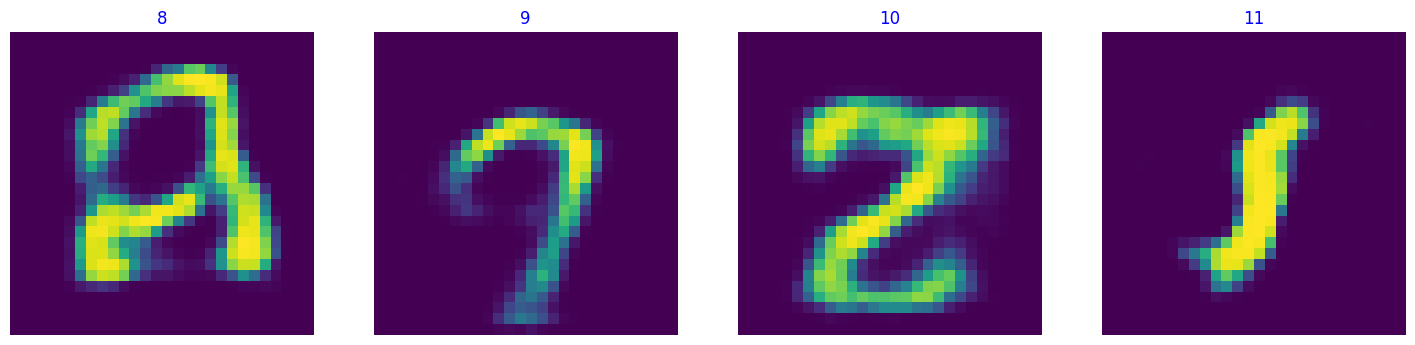

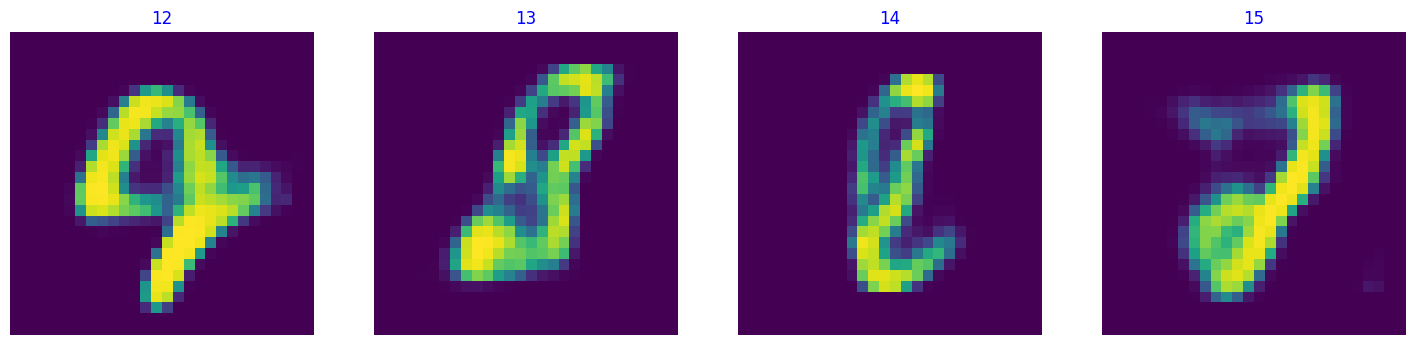

In [11]:
# When model is trained for epoch = 100


# generating a few samples 
N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_image(None, sample, N//4, count=True)

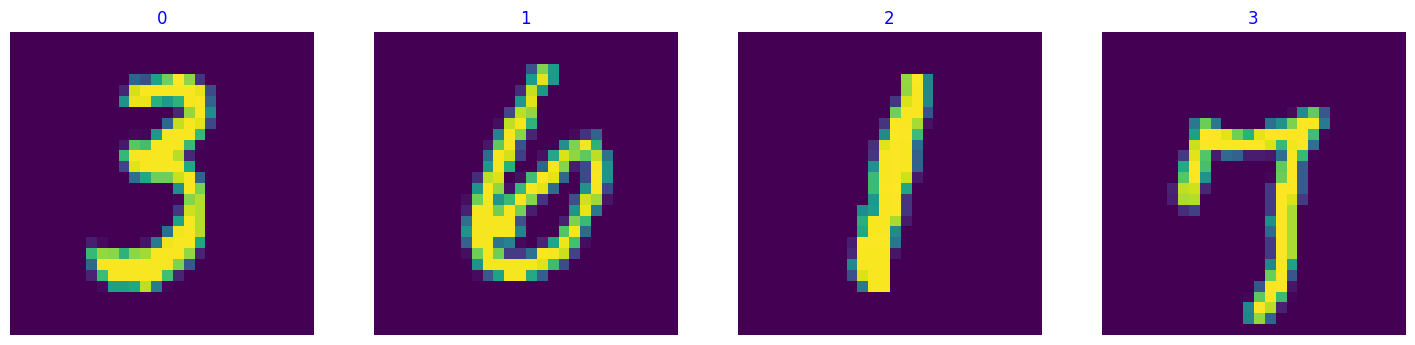

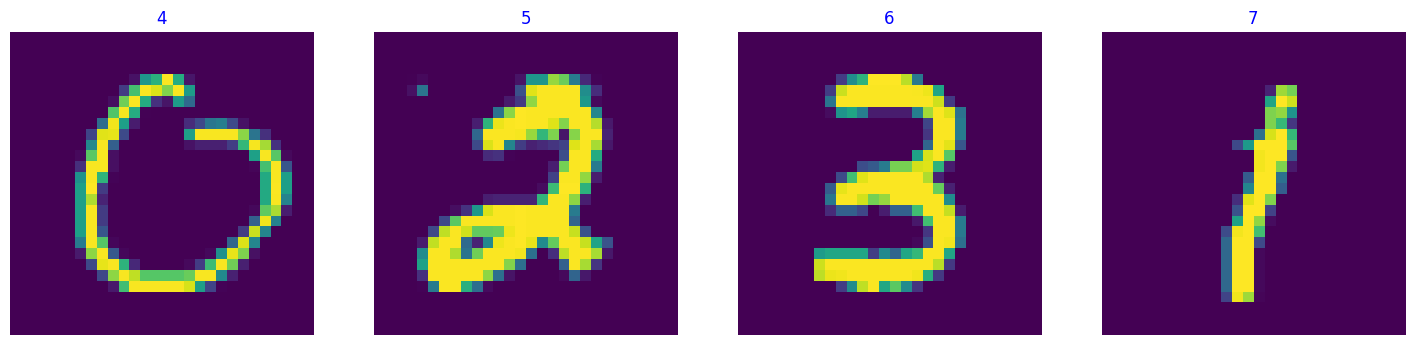

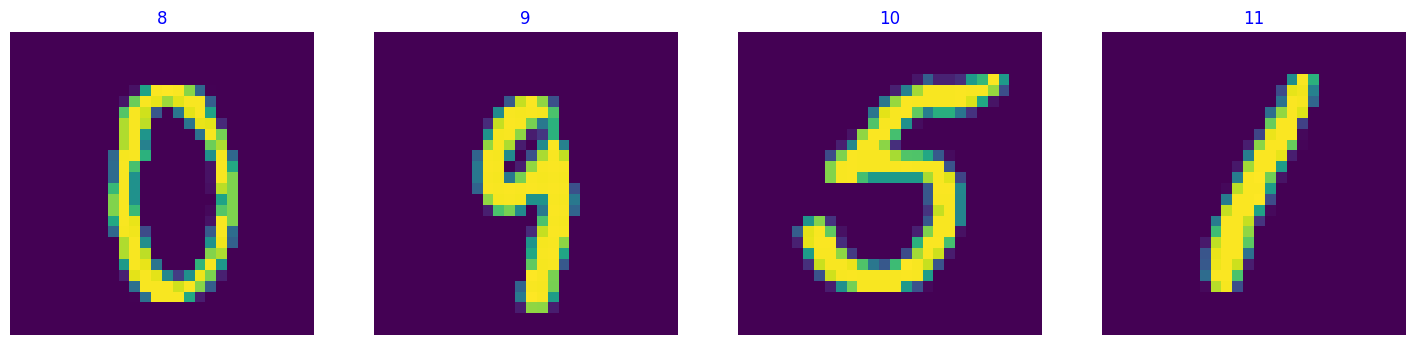

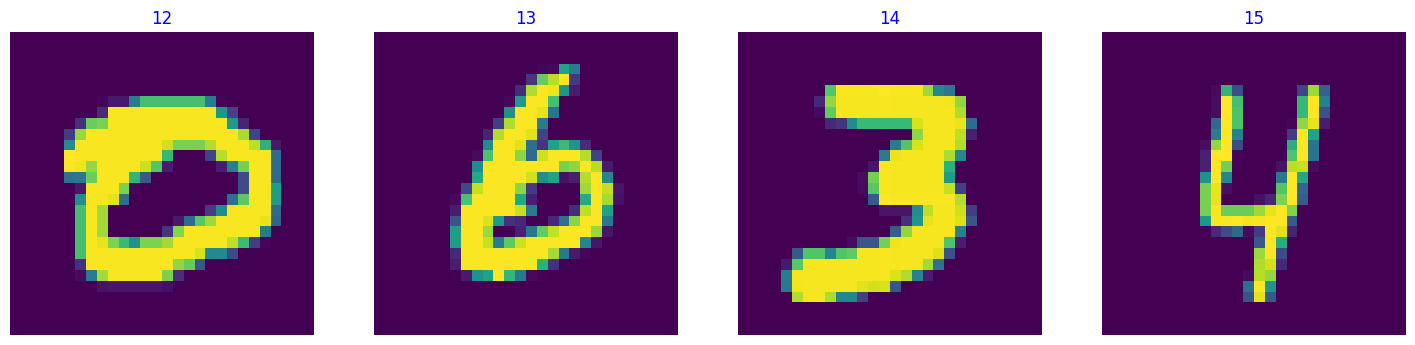

In [12]:
display_image(None, x, 4, count=True)

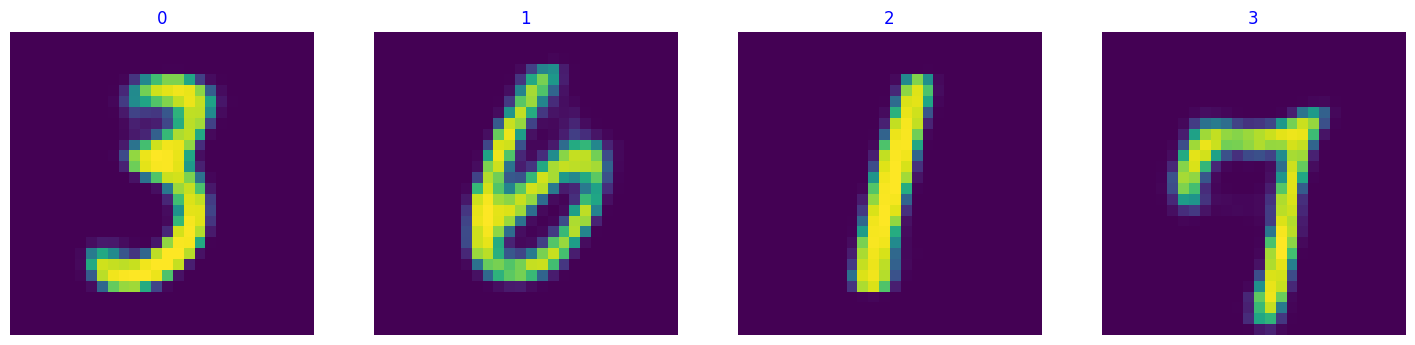

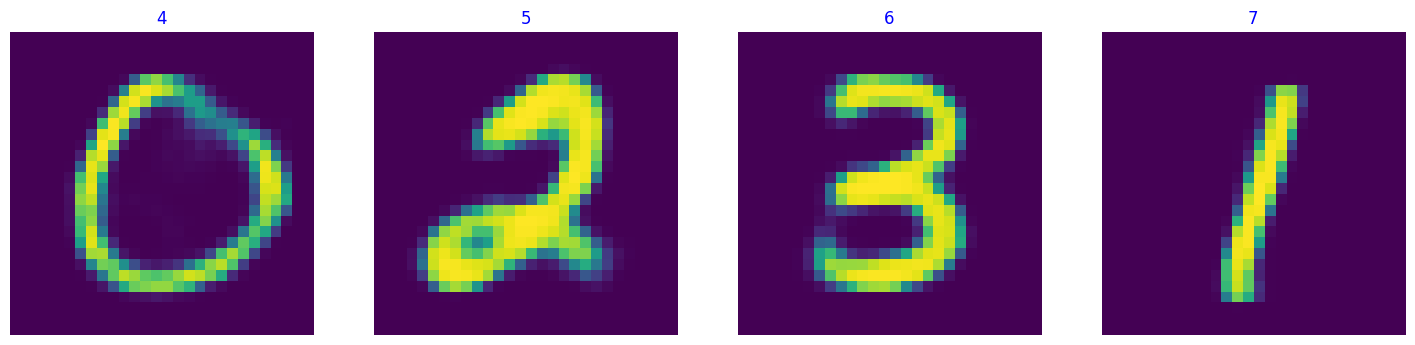

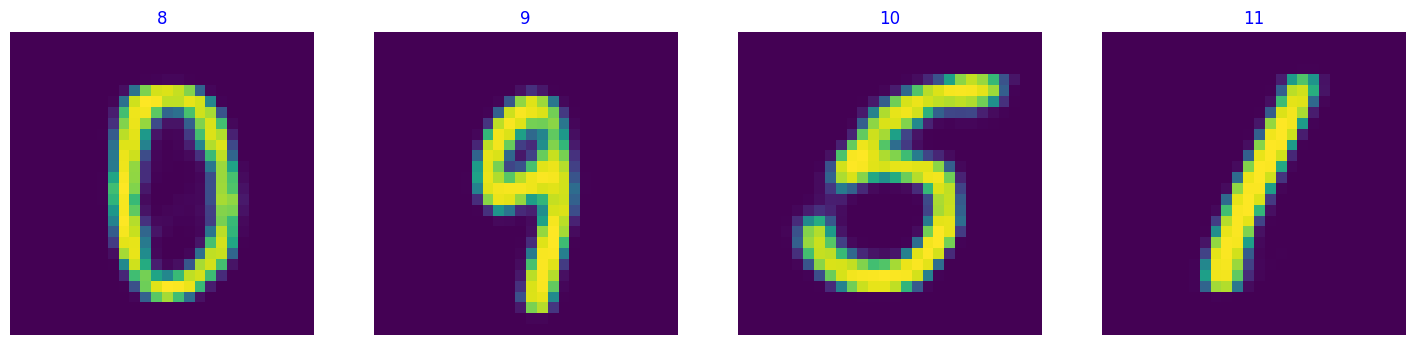

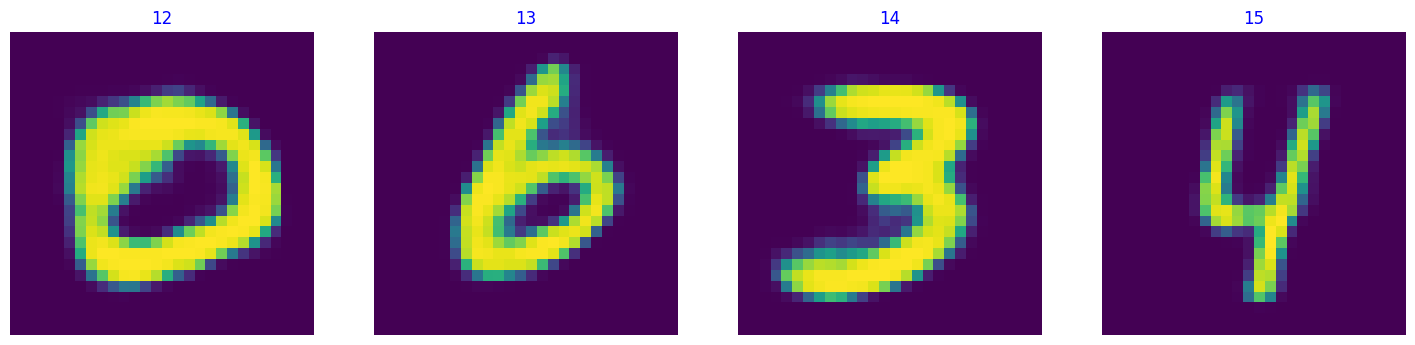

In [13]:
display_image(None, x_hat, 4, count=True)

# Passing Random Value to decoder

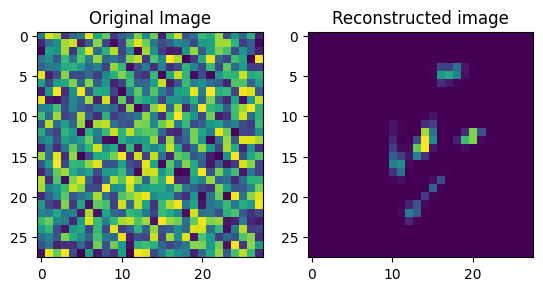

In [14]:



import torchvision.transforms.functional as F
image =  torch.randn((1,28,28)).to(device)
img_data = F.to_pil_image(image)

reconstructed_output, mu_test, logvar_test = model(image.to(device))
reconstructed_output = reconstructed_output.data.cpu().view(-1, 28, 28)
recon_img_data = F.to_pil_image(reconstructed_output)


# Create a figure with two subplots (1 row, 2 columns)
plt.subplot(1, 2, 1)  # The third argument is the index of the subplot
plt.imshow(img_data)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(recon_img_data)
plt.title('Reconstructed image')

plt.show()


# Passing a test data to decoder

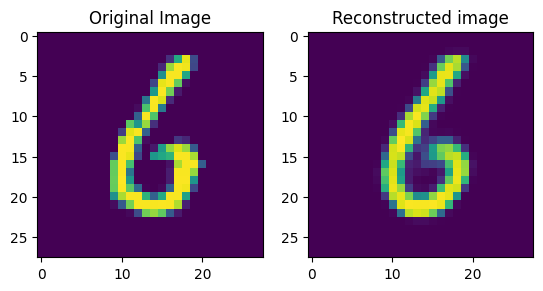

In [15]:
import torchvision.transforms.functional as F
image = test_dataloader.dataset[50][0]
img_data = F.to_pil_image(image)

reconstructed_output, mu_test, logvar_test = model(image.to(device))
reconstructed_output = reconstructed_output.data.cpu().view(-1, 28, 28)
recon_img_data = F.to_pil_image(reconstructed_output)


# Create a figure with two subplots (1 row, 2 columns)
plt.subplot(1, 2, 1)  # The third argument is the index of the subplot
plt.imshow(img_data)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(recon_img_data)
plt.title('Reconstructed image')

plt.show()


# Trying to construct a number by tweaking a image of another number

e.g.
When I provide image of number `3` and trying to construct the image of `8`

<center>
    <h1> 3 to 8</h1>
</center>

<center><img src="https://github.com/saurabtharu/autoencoder/blob/main/images/vae/interpolation.png?raw=true" style="height: 10;"></center>



# Example 
<center>
    <h1> dog to bird</h1>
</center>

<center><img src="https://github.com/saurabtharu/autoencoder/blob/main/images/vae/dog_to_bird.png?raw=true" style="height: 10;"></center>

<br><br>
<br>

## Interpolated
<center><img src="https://github.com/saurabtharu/autoencoder/blob/main/images/vae/interpolated-dog_to_bird.png?raw=true" style="height: 10;"></center>

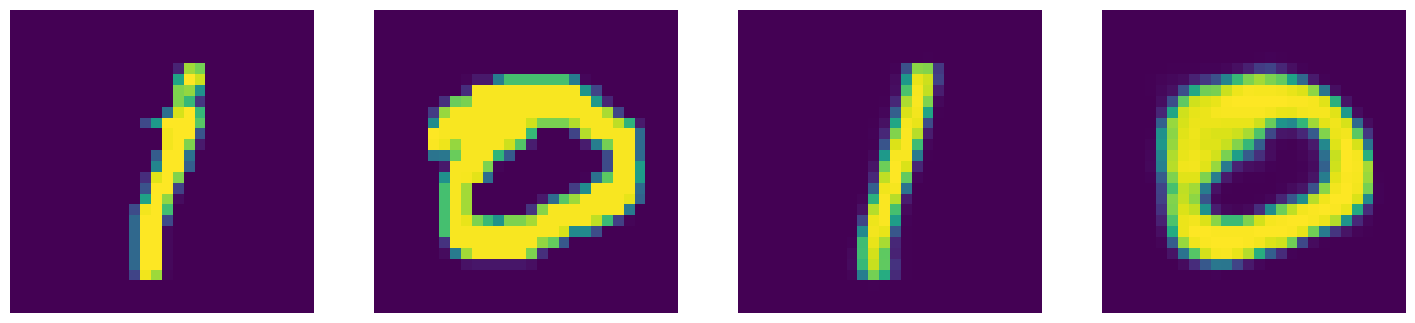

In [20]:
# Choose the starting and ending point for the interpolation -> original and reconsructed

A, B = 7, 12
# A, B = 9, 11
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_image(None,
             torch.stack(((
                 x[A].data.view(-1),
                 x[B].data.view(-1),
                 sample.data[0],
                 sample.data[1]
             )), 0))

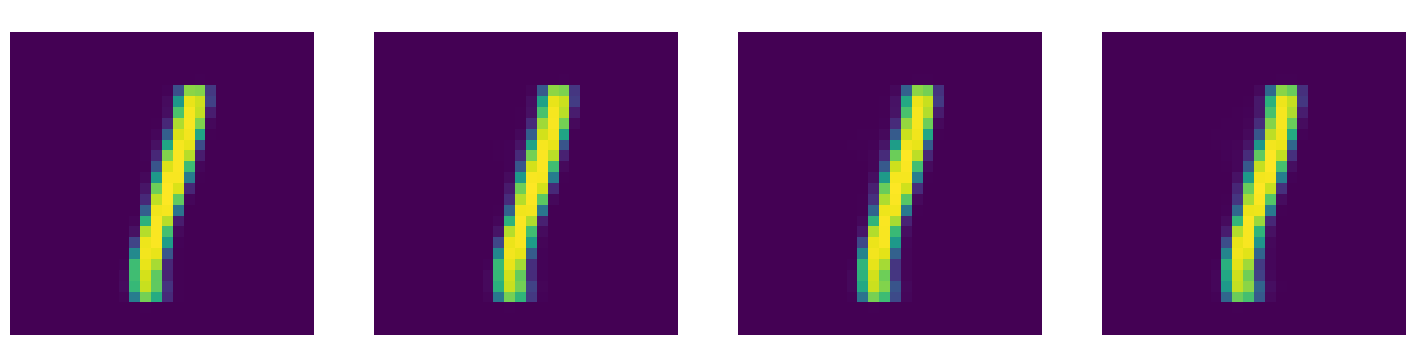

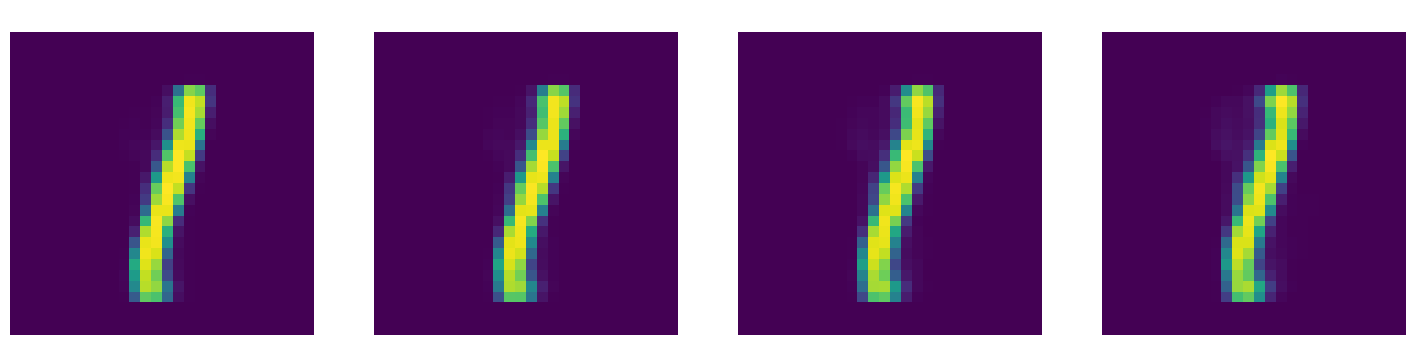

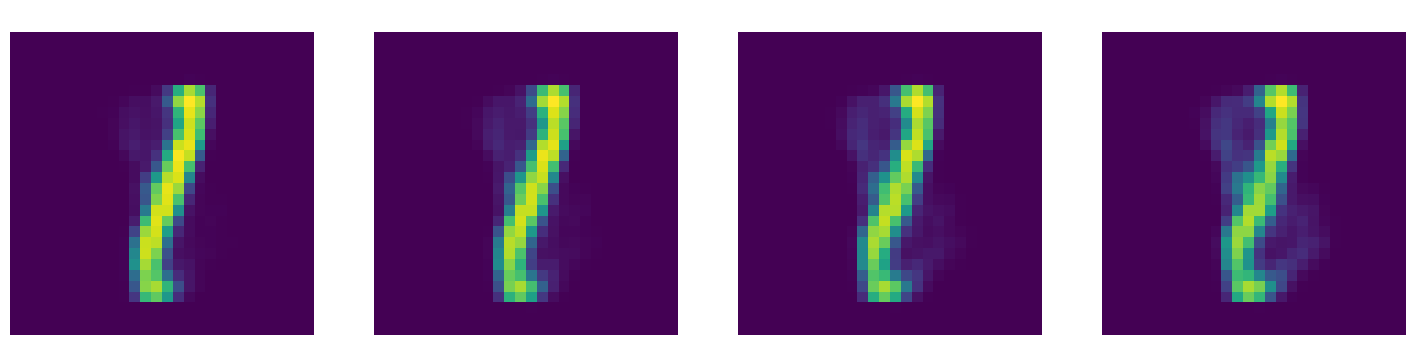

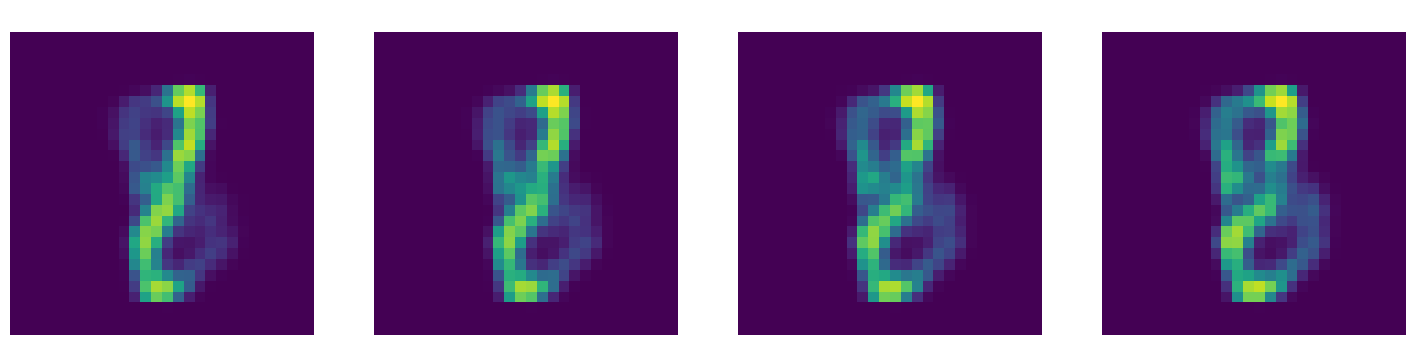

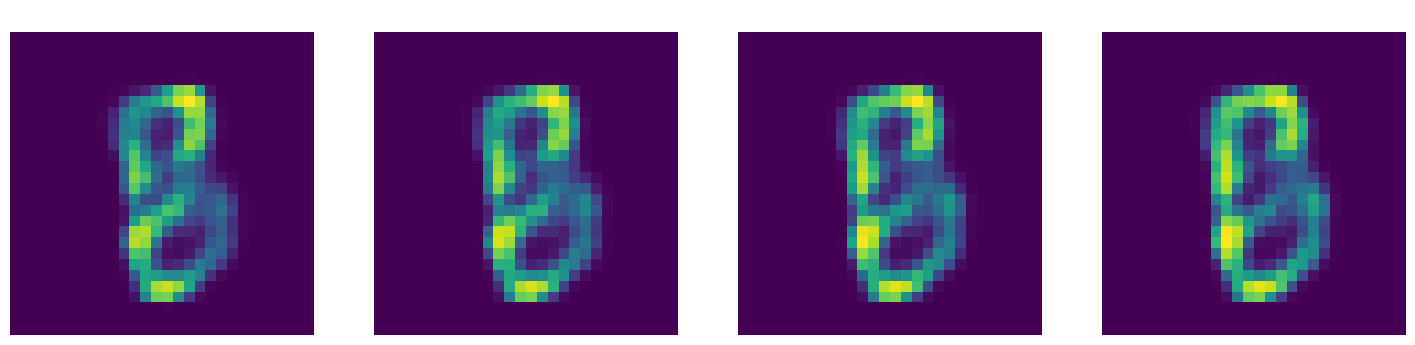

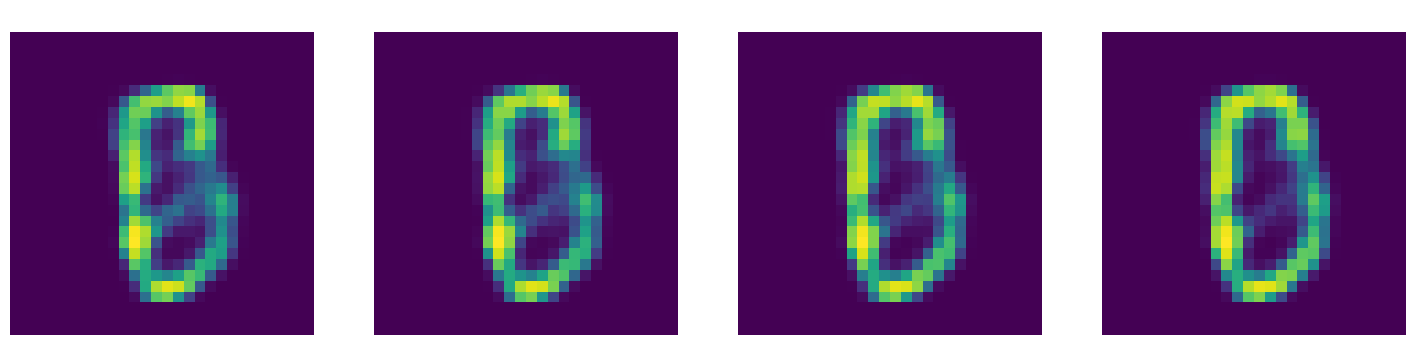

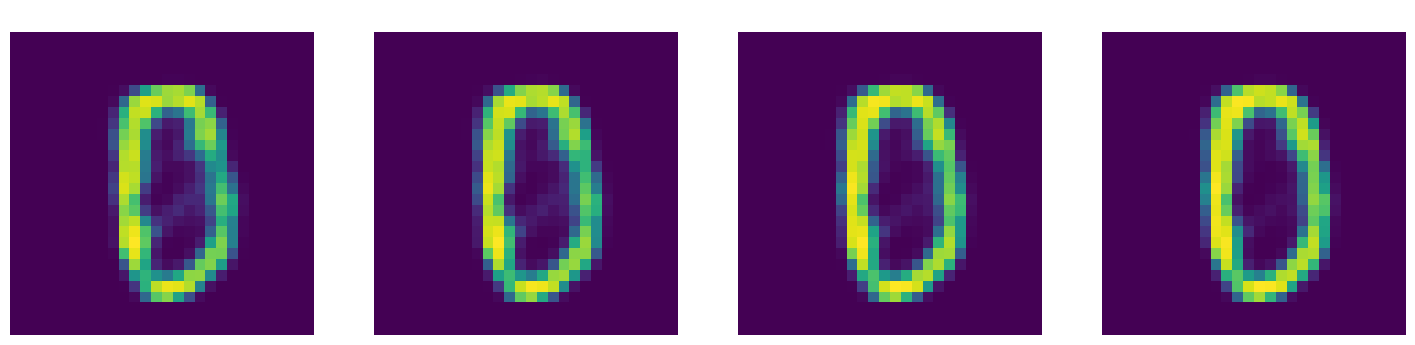

In [22]:
# Performing interpolation between input A and B, in N stops
N = 30
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N-1) * mu[8].data + (1 - i / (N - 1)) * mu[A].data

sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)